# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

Name: Sadjad Bazarnovi <br>
Email: sbazar3@uic.edu <br>
UIN: 679314994 <br>

please add your information here

## 1. CNNs and finetuning

### Preprocessing

First we specify some data augmentations with [Transforms V2](https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html) for both the training and testing sets. The following transforms are applied to the `train_transform` object:

- `RandomRotation`: Rotates the image between 0 and 30 degrees
  
- `RandomHorizontalFlip`: Randomly flips an image along the horizontal axis
  
- `ToImageTensor`: transforms input image into a `torch.Tensor`
  
- `ConvertImageDtype`: converts elements in tensors to `float32` dtype – necessary for development on M-series MacBooks.
  
- `Normalize`: Normalize tensor values such that the mean and standard deviation of the images become `0.0` and `1.0` respectively. Per-color mean and standard deviation values were calculated w.r.t. this [guide](https://saturncloud.io/blog/how-to-normalize-pytorch-cifar10-images-for-improved-model-performance/).

We instantiate an `unaugmented_transform` object as well to create test and validation validation datasets without any augmentations.

In [1]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

Torch Device: mps


We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [2]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 64:

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

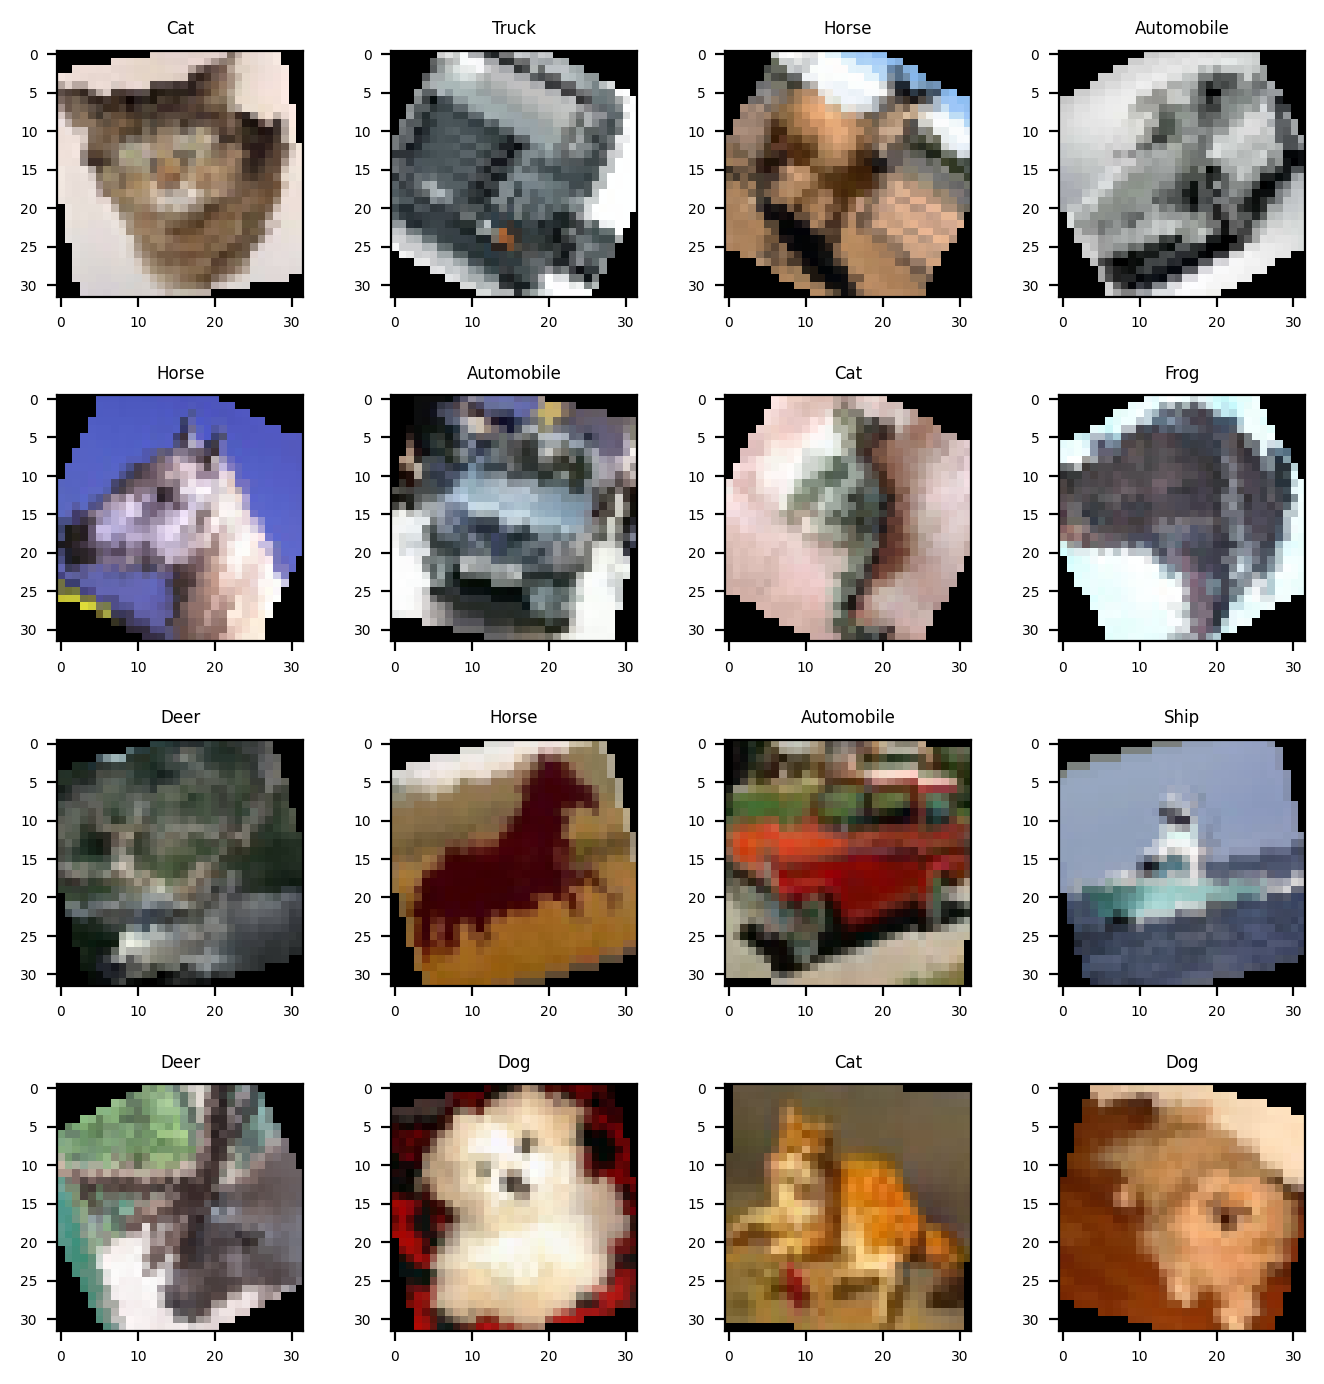

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=200)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

### Transfer learning model

We download the previoulsy constructed `resnet18` model from the `torchvision.models` module and instantiate the model with the default ResNet18 weights. In order to extract features from the data, the paramters in the model are frozen and the final layer `fc` is replaced with a linear layer with 10 outputs using the `torch.nn` linear class.

We additionally specify the loss `criterion` and `optimizer` algorithm for our training loop.
- `CrossEntropyLoss()` loss function was selected to train classification with _C_ classes.
- `Adam` optmizer was selected due to it's performant qualities while training. A learning rate `lr = 1e-3` was selected as it's a common choice that performs well with vision models.

In [9]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

# create transfer learning model
resnet18_based = resnet18(weights=ResNet18_Weights.DEFAULT)

# freeze model parameters
for param in resnet18_based.parameters():
    param.requires_grad = False

# replace last fully connected layer
num_ftrs = resnet18_based.fc.in_features
resnet18_based.fc = nn.Linear(num_ftrs, 10)

# move model to GPU
resnet18_based.to(device)

# create loss function
criterion = nn.CrossEntropyLoss()

# select optimizer for training
optimizer = optim.Adam(resnet18_based.fc.parameters(), lr=1e-3)

### Training

We can now devise a training loop for our `resnet18_based` model. Each epoch iteration performs a forward and backward pass per batch in the training data and evaluates on validation data after each epoch. The function returns a dictionary containing the model and relevant training statistics.

In [10]:
from tqdm.notebook import tqdm

# define a function to compute accuracy
def calculate_accuracy(outputs, labels):
    
    softmax = nn.Softmax(dim = 1)
    
    outputs = softmax(outputs)
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model(model, criterion, optimizer, train_loader: DataLoader, 
                val_loader: DataLoader = None, scheduler = None, num_epochs=25, verbose = 5):

    # model training history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        
        train_loss = 0
        total_accuracy = 0
        
        # Iterate over data.
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass and loss calculation
            with torch.set_grad_enabled(True):
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)        

                # backward pass
                loss.backward()
                optimizer.step()

            # training loss per batch    
            train_loss += loss.item()
            
            # training statistics
            batch_accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += batch_accuracy
            
        # update scheduler
        if scheduler != None:
            scheduler.step()

        # validation on epoch
        if val_loader != None:

            # training statistics
            val_loss = 0
            val_accuracy = 0

            # set model to evaluation
            model.eval()

            for data in val_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass and loss calc
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

                val_batch_accuracy = calculate_accuracy(outputs, labels)
                val_accuracy += val_batch_accuracy

        # Calculate average accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader)
        train_acc_history.append(epoch_accuracy)
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        if val_loader != None:
            
            epoch_val_accuracy = val_accuracy / len(val_loader)
            val_acc_history.append(epoch_val_accuracy)
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(float(epoch_val_loss))
            
            print('Validation Loss: {:.4f}\tValidation Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_accuracy))

    history = {
        "model": model.to("cpu"),
        "train loss": train_loss_history,
        "validation loss": val_loss_history,
        "train accuracy": train_acc_history,
        "validation accuracy": val_acc_history
    }    

    return history


trained_resnet18_based = train_model(resnet18_based, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.8823	Train Accuracy: 0.3313
Validation Loss: 1.7701	Validation Accuracy: 0.3774

Epoch 2/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7836	Train Accuracy: 0.3697
Validation Loss: 1.7743	Validation Accuracy: 0.3754

Epoch 3/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7627	Train Accuracy: 0.3771
Validation Loss: 1.7671	Validation Accuracy: 0.3811

Epoch 4/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7627	Train Accuracy: 0.3785
Validation Loss: 1.7801	Validation Accuracy: 0.3845

Epoch 5/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.7583	Train Accuracy: 0.3808
Validation Loss: 1.7515	Validation Accuracy: 0.3831



The `trained_classifier` dictionary can now be passed to the `model_history()` function to plot accuracy and loss history.

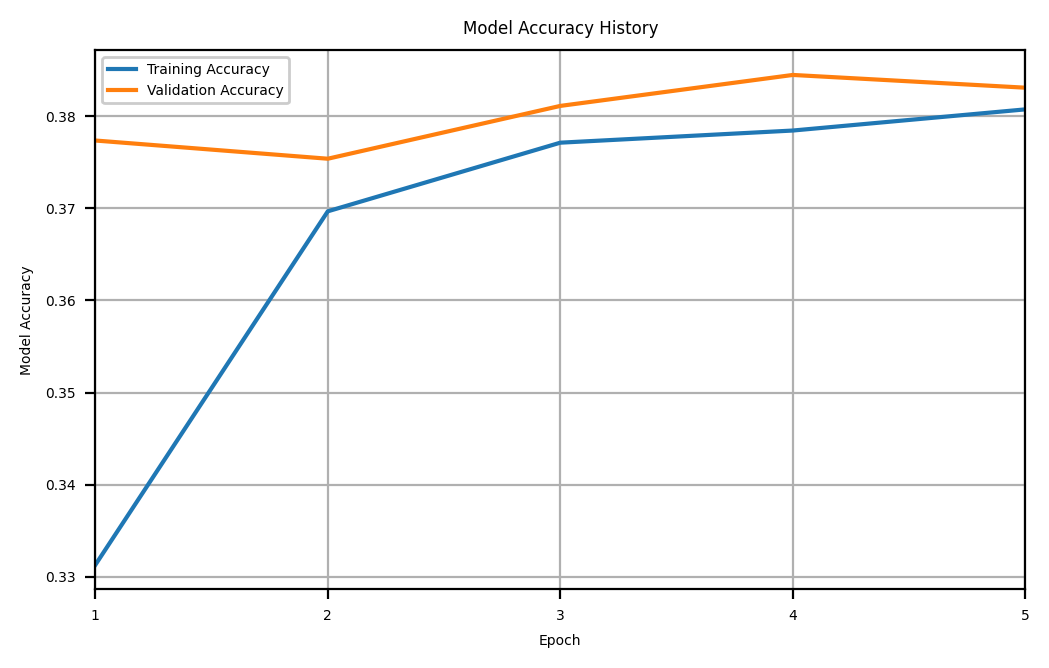

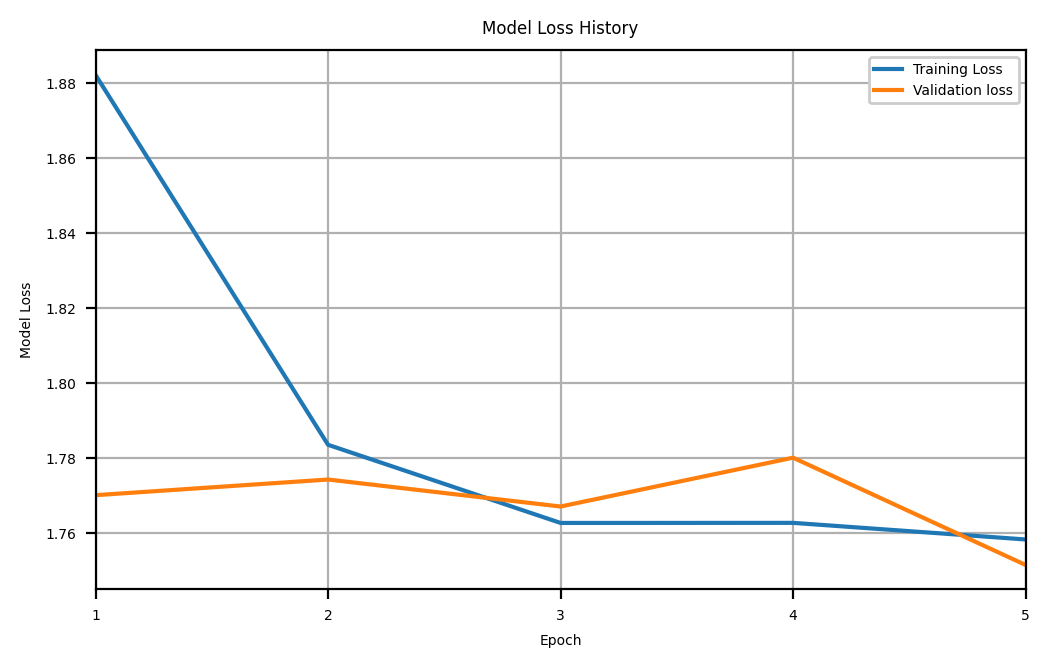

In [11]:
# create function to show model training accuracy and loss history
def model_history(history):
        # plot training history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train accuracy'])+1),
                history['train accuracy'],
                label = r'Training Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation accuracy"])+1),
                history['validation accuracy'],
                label = r'Validation Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Accuracy History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Accuracy')
        ax.set_xlim(1, len(history["train accuracy"]))
        ax.set_xticks(list(range(1,len(history["train accuracy"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

        # plot loss history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train loss'])+1),
                history['train loss'],
                label = r'Training Loss',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation loss"])+1),
                history['validation loss'],
                label = r'Validation loss',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Loss History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Loss')
        ax.set_xlim(1, len(history["train loss"]))
        ax.set_xticks(list(range(1,len(history["train loss"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

# plot training history using the function
model_history(trained_resnet18_based)

### Transfer Learning Model Evaluation

#### Test Accuracy

We next define the `evaluation()` function to evaluate the trained model on the `extracted_test_loader` DataLoader. Similar to our training loop, this function returns a dictionary of relevant items for analysis and further visual inspection.

In [13]:
from sklearn.metrics import accuracy_score

def evaluate(history, test_loader):
    
    model = history["model"]

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1).to(device)
    
    probs_list = []
    y_true = []
    
    test_loss = 0
    
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.append(labels)

        with torch.no_grad():
            
            # forward pass and loss on model
            linear_outputs = model(inputs)
            loss = criterion(linear_outputs, labels)

        # apply softmax layer
        outputs = softmax(linear_outputs)
        
        # add loss to total
        test_loss += loss.item()
        
        # append softmax probabilities to probs_list
        for prob, label in zip(outputs, labels):
            probs_list.append(prob.cpu().tolist())
            
    
    y_true = torch.cat(y_true, dim=0).cpu()
    
    # compute total loss on test set
    test_loss /= len(test_loader)
    
    # get predicitons
    y_pred = list(np.argmax(np.asarray(probs_list), axis = 1))
    
    # report accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print("Test Accuracy:", accuracy)
    print("Test Loss: {:.4f}".format(test_loss))
    
    # return dictionary
    evaluation = {
        "accuracy": accuracy,
        "loss": test_loss,
        "y_pred": list(y_pred),
        "y_true": list(y_true),
        "probs": list(probs_list)
    }
    
    return evaluation
        
test_results = evaluate(trained_resnet18_based, test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.3828
Test Loss: 1.7482


The transfer learning model performed with a test accuracy of XX.XX%. While not successful enough for say deployment at scale, it did succeed in being a better predictor than the naive predictor accuracy of 10%.

In [26]:
total_params = sum(p.numel() for p in resnet18_based.fc.parameters())
print(f"Number of trainable parameters: {total_params}")

Number of parameters: 5130


The low accuracy of this model can be attributed to the relatively small number of trainable parameters (5,130) to the size of the training data (50,000 instances). The model is unable to generalize well given the number of parameters it has at its disposal.

#### Confusion Matrix Analysis
In addition to test accuracy, a confusion matrix can be displayed to further evaluate model performance.

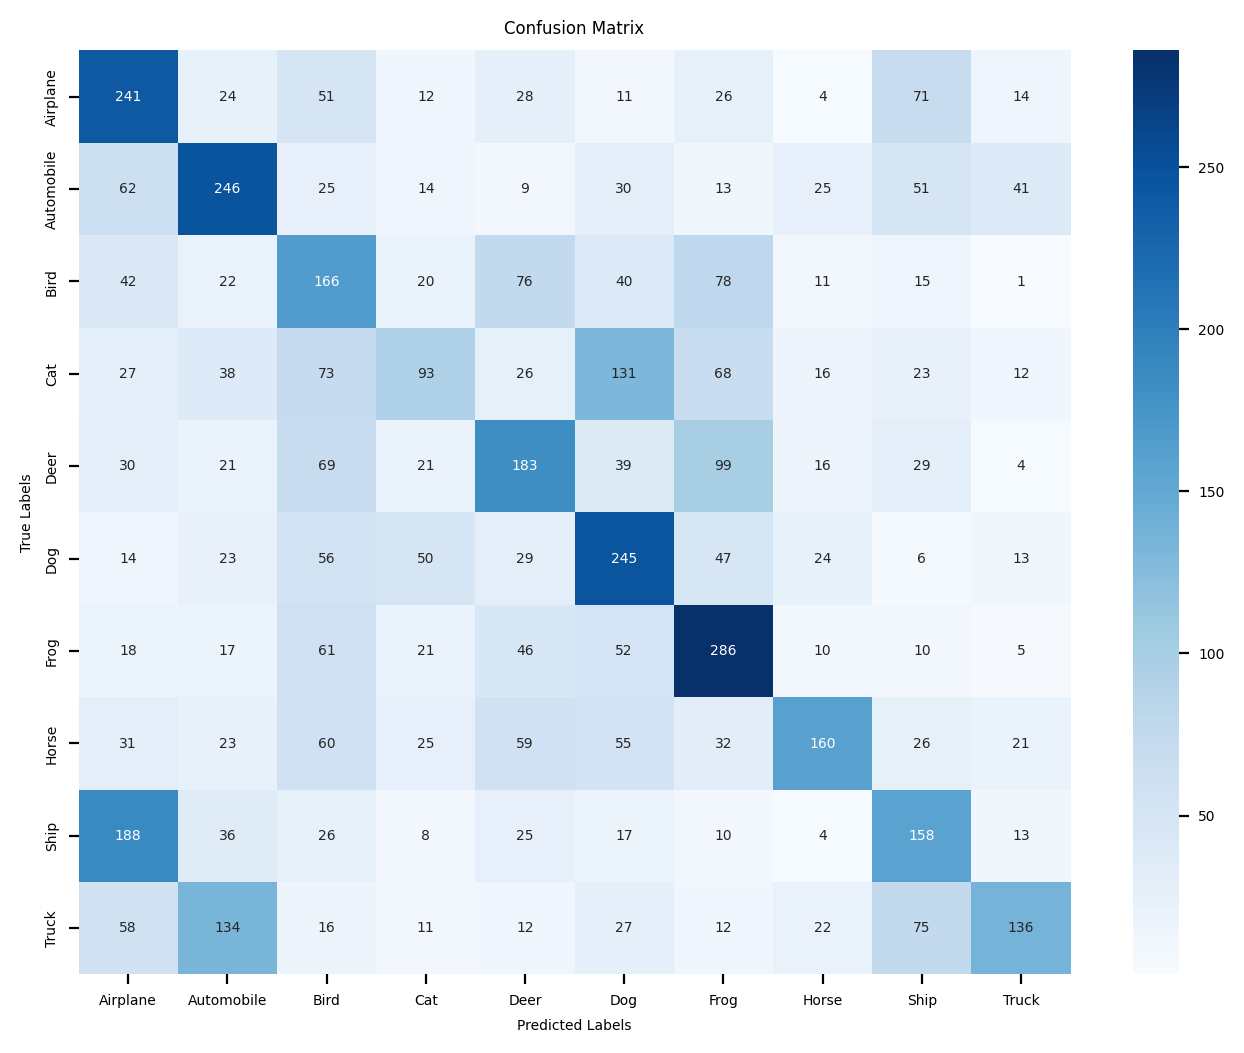

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_results):

    # generat confusion matrix
    cm = confusion_matrix(test_results["y_true"], test_results["y_pred"])

    plt.figure(figsize=(8, 6), dpi = 200)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=CIFAR10_labels.values(), yticklabels=CIFAR10_labels.values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(test_results)


Add analysis of confusion matrix here

#### Predictions
The results generated from the `evaluate()` function can then be manipulated with `pandas` to obtain the top correct and incorrect predictions in terms of predicted class probability.

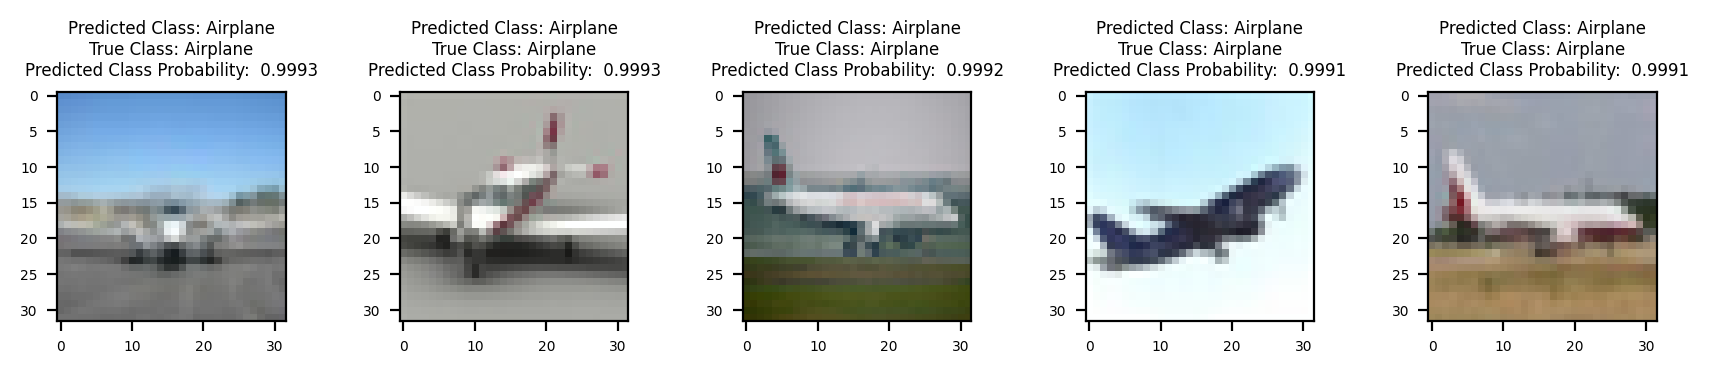

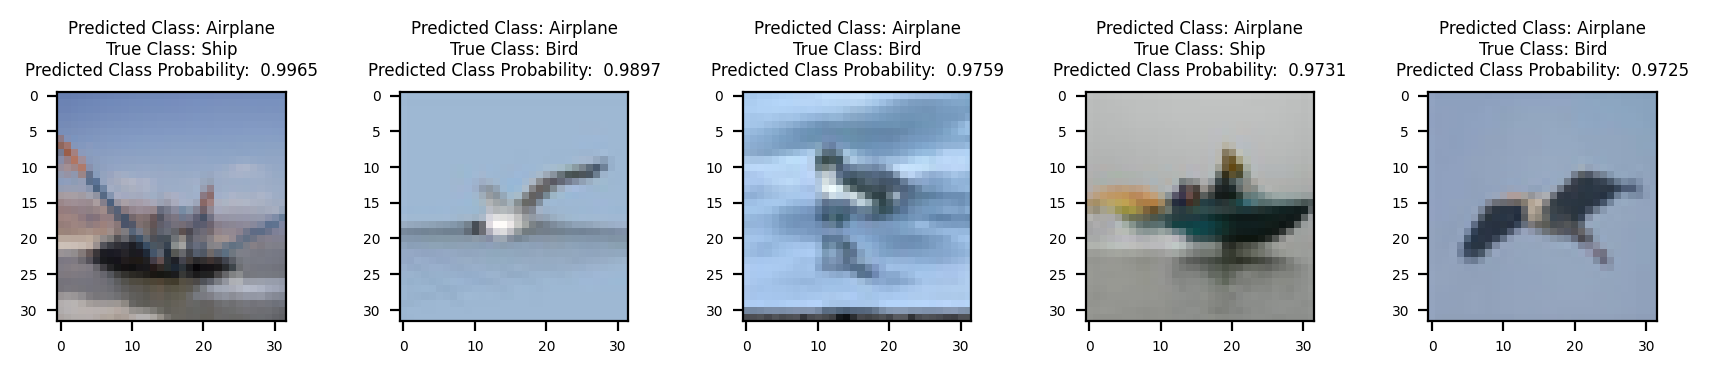

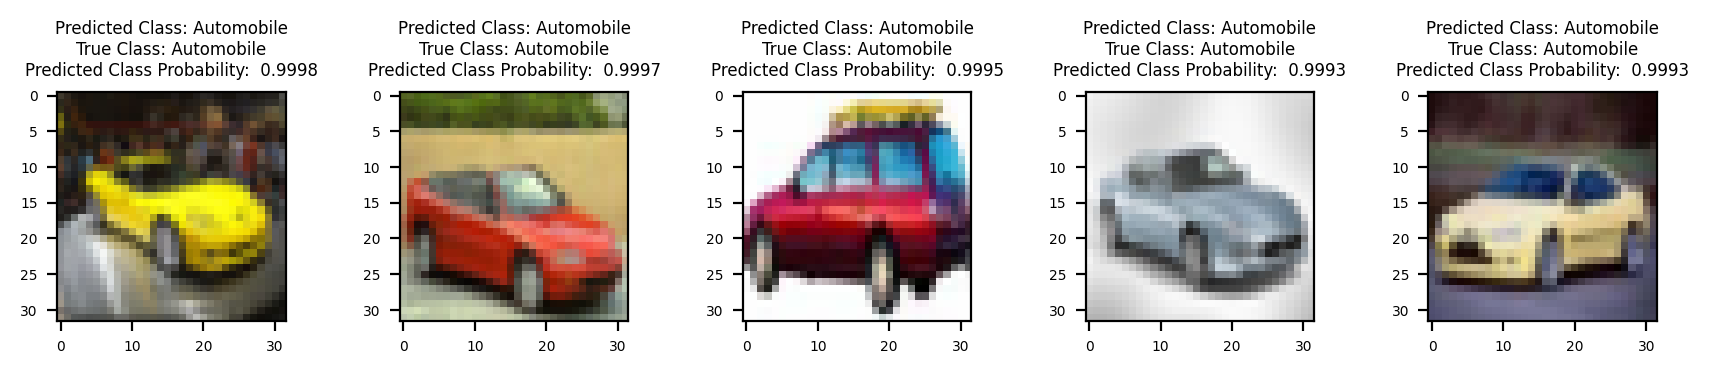

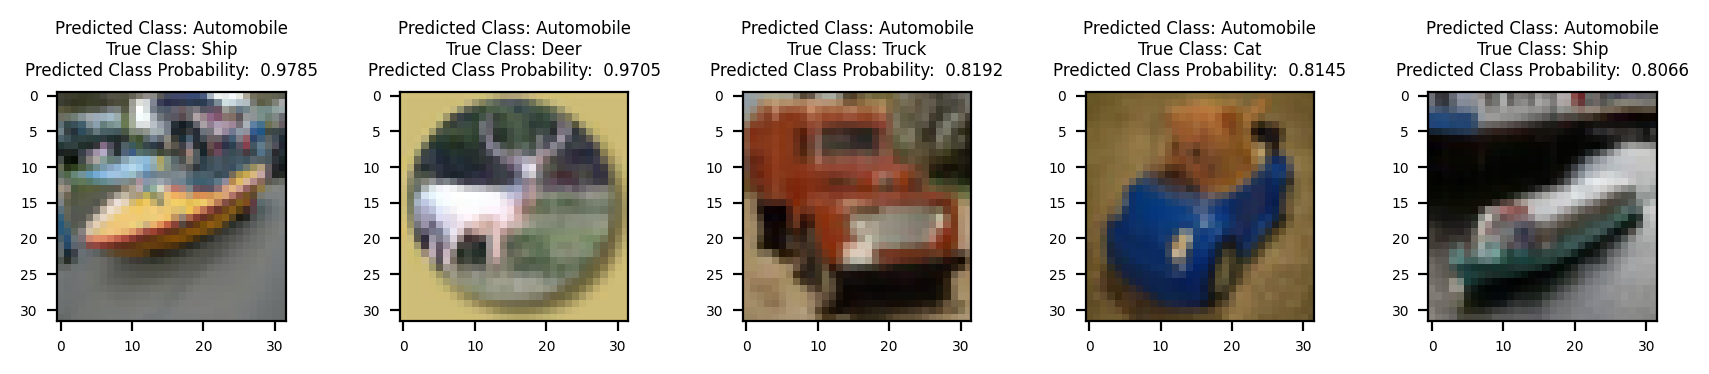

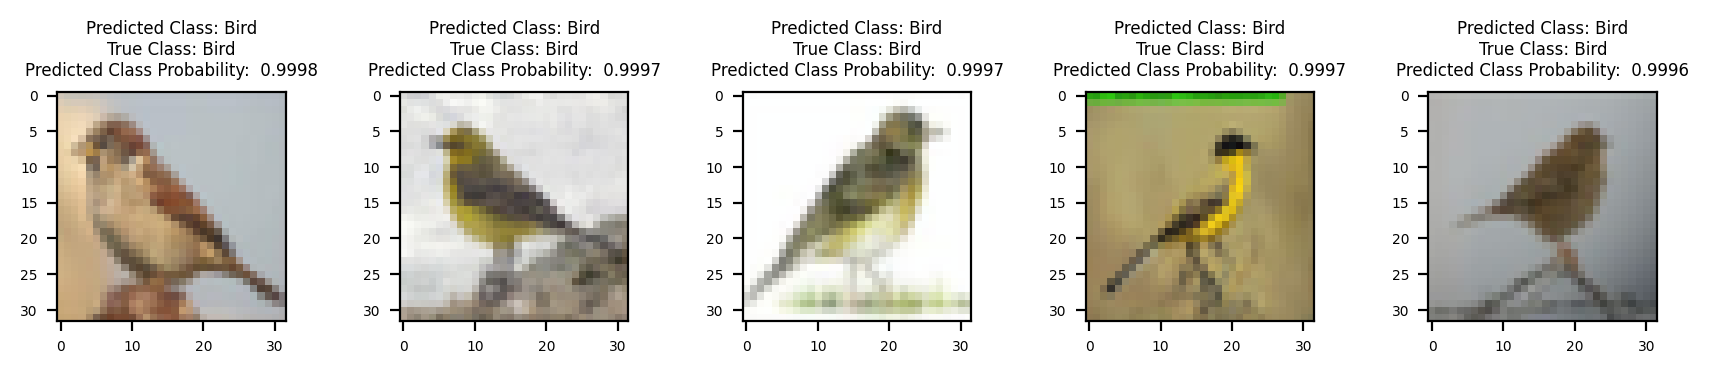

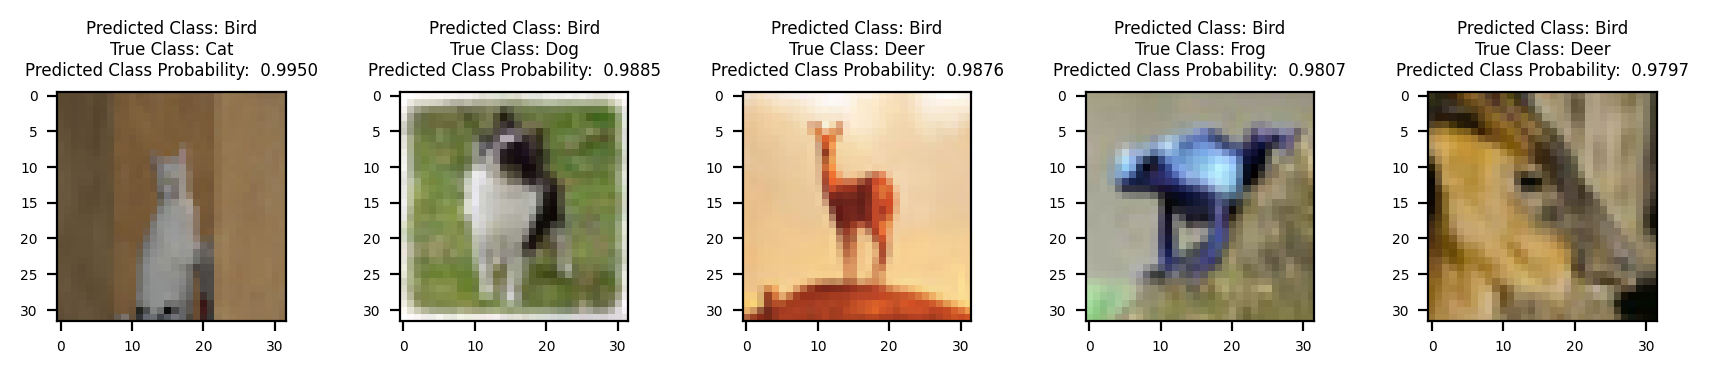

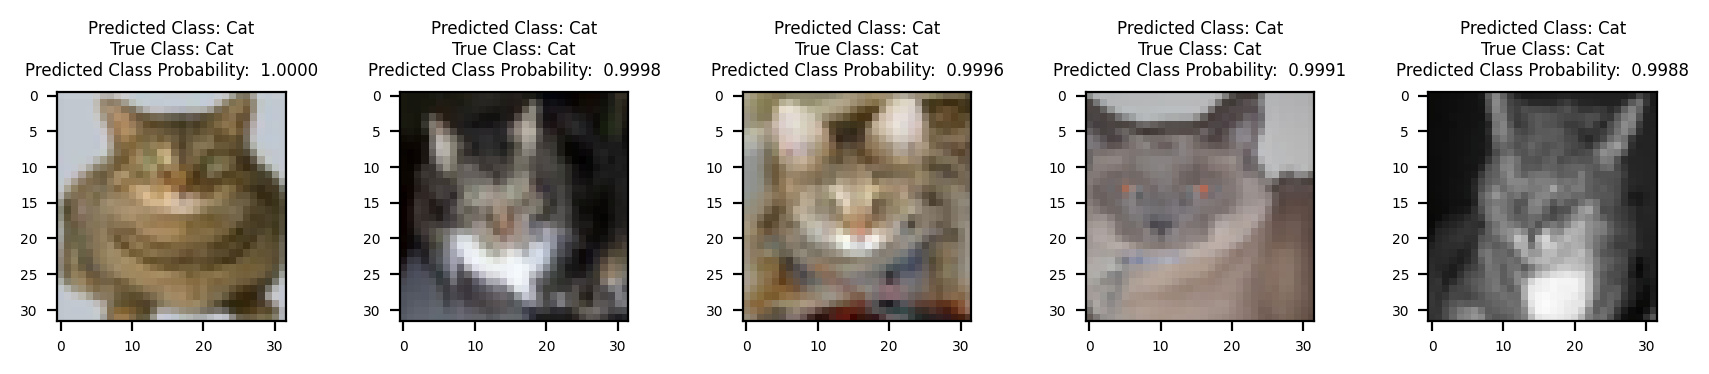

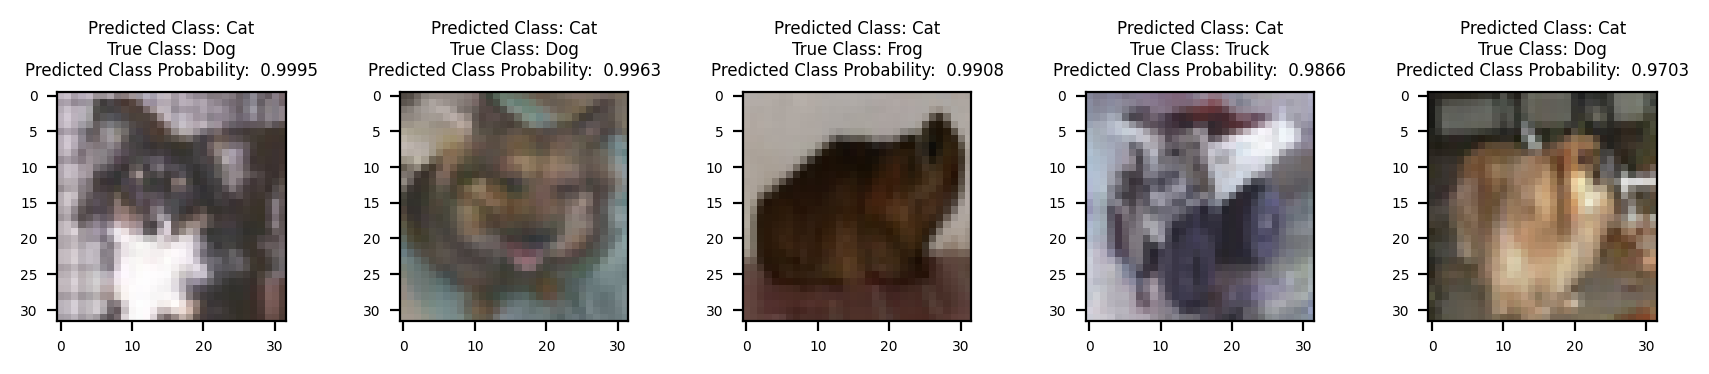

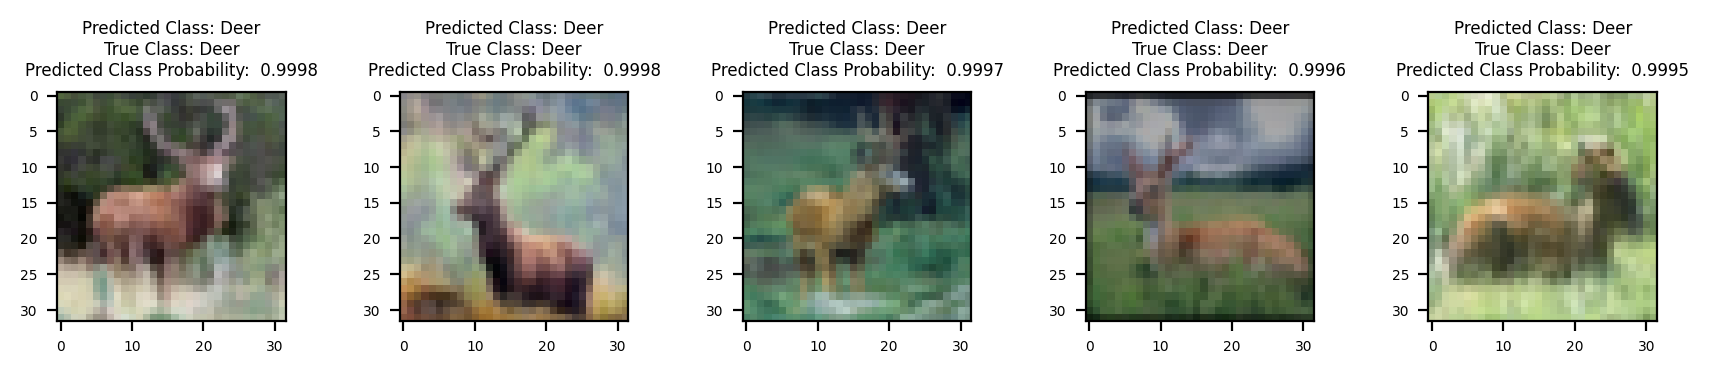

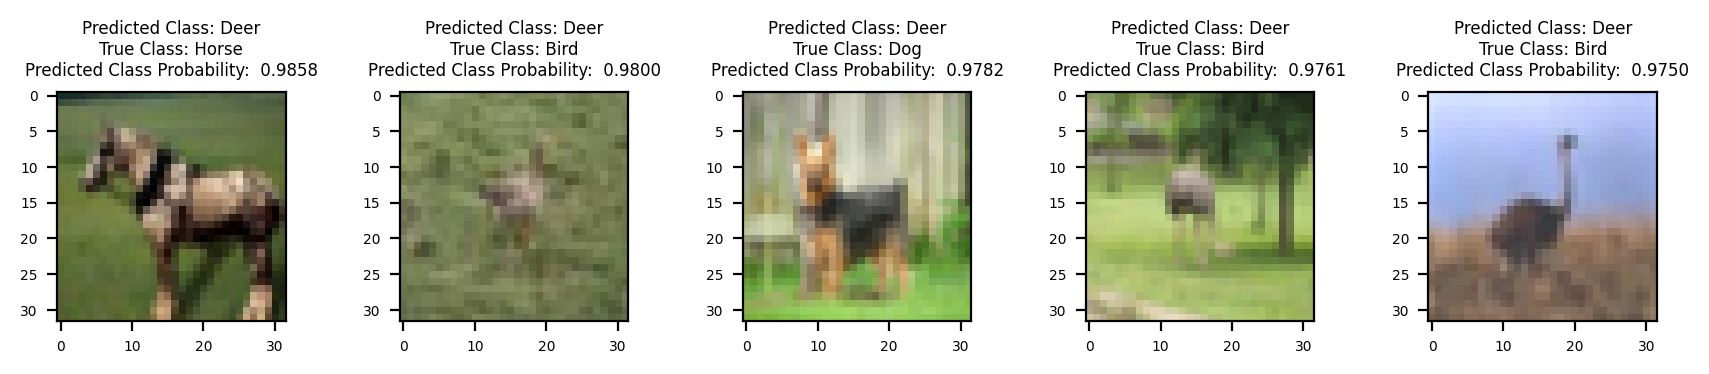

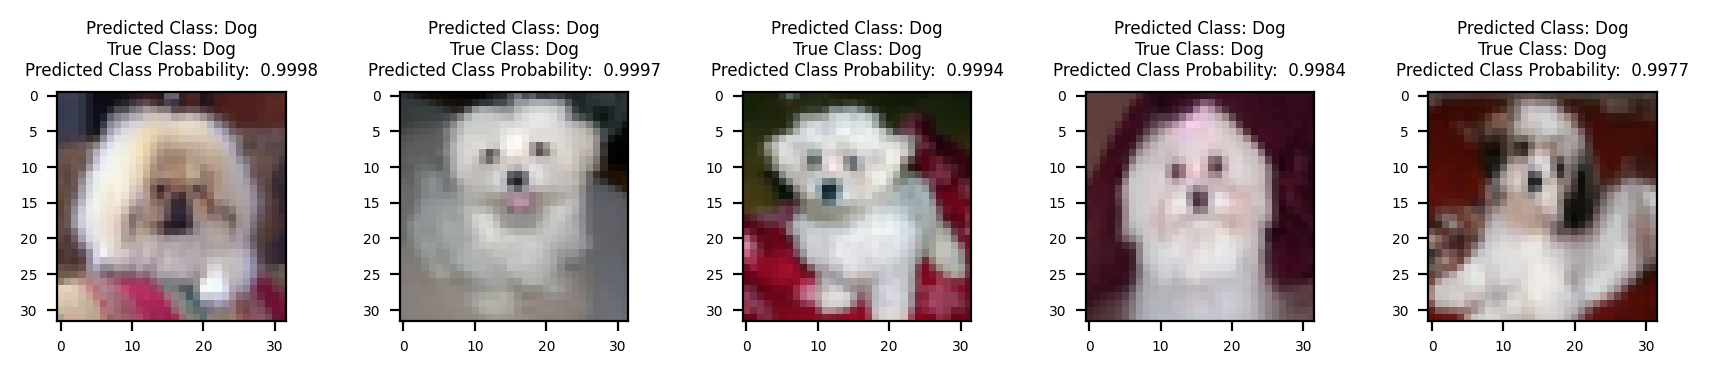

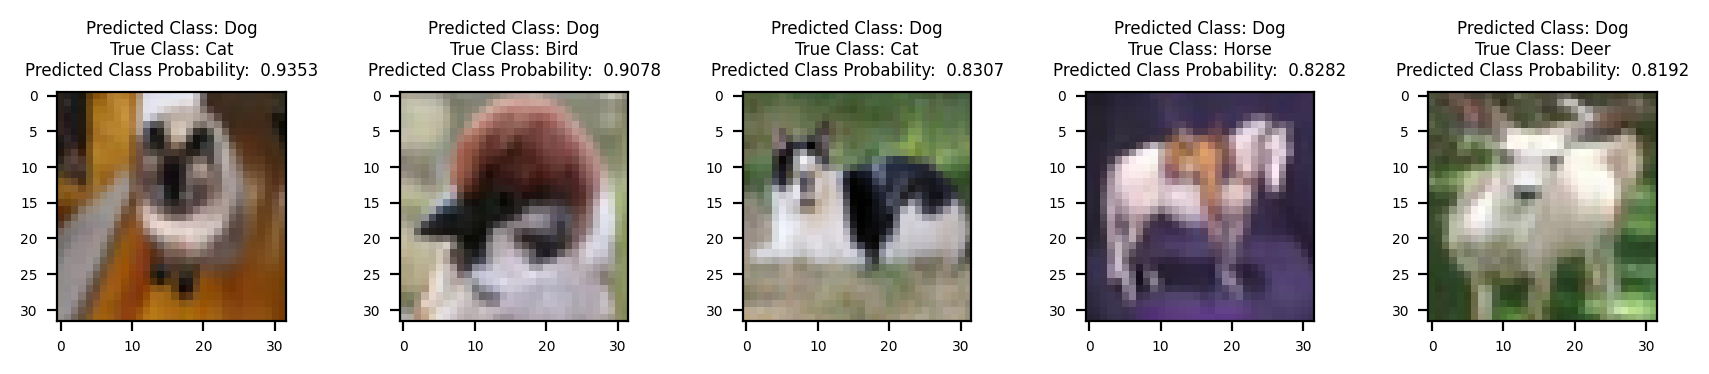

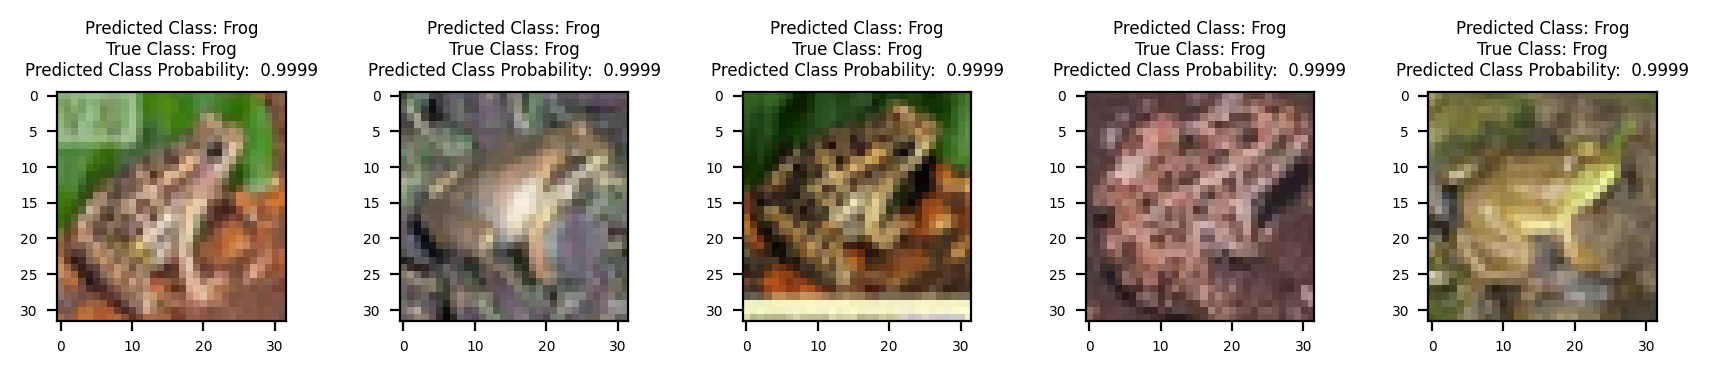

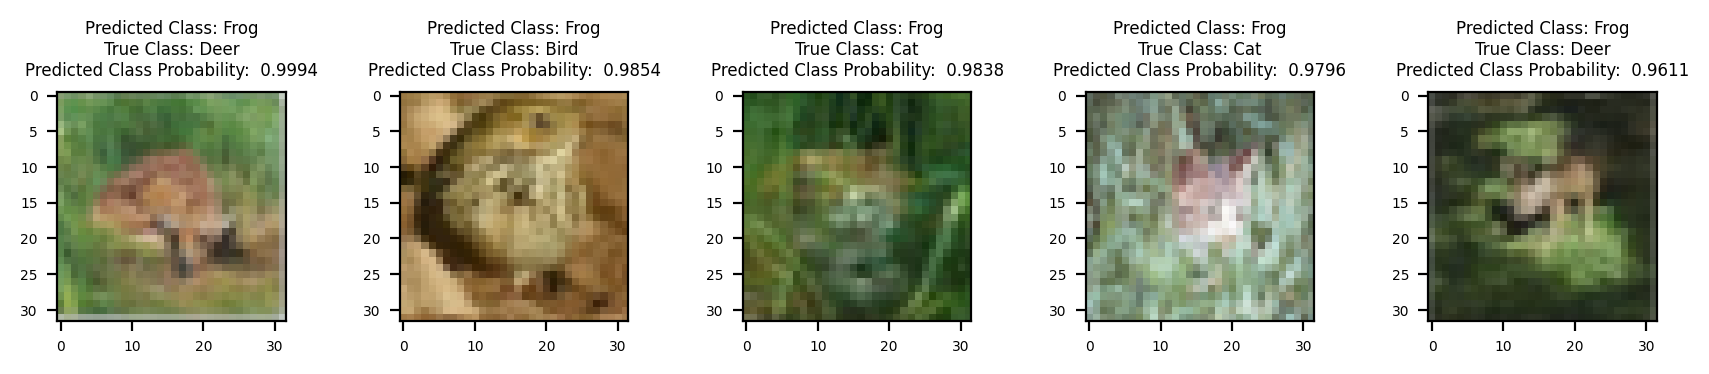

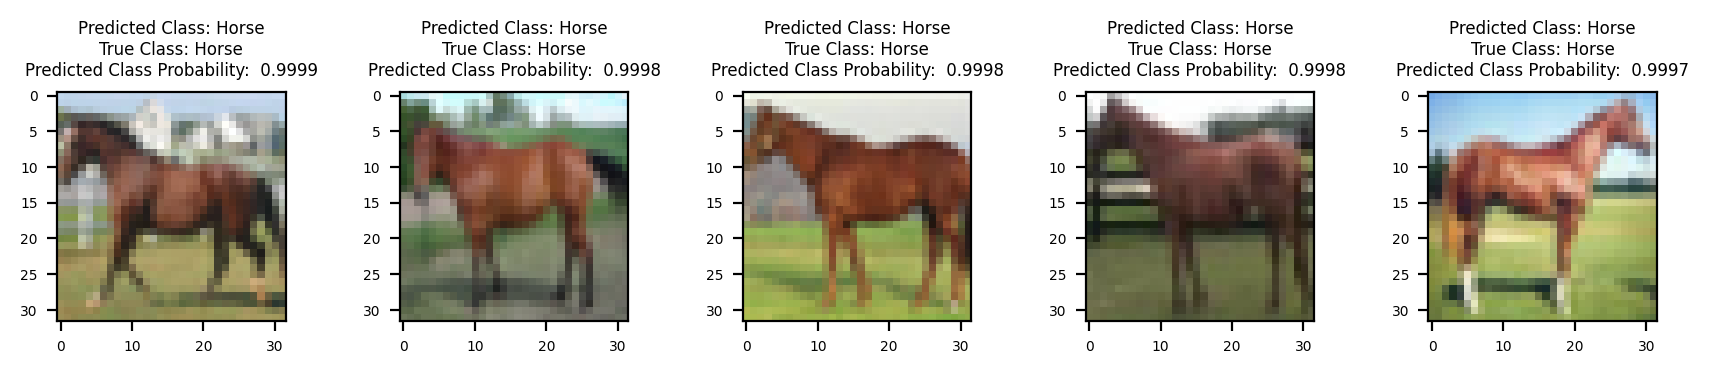

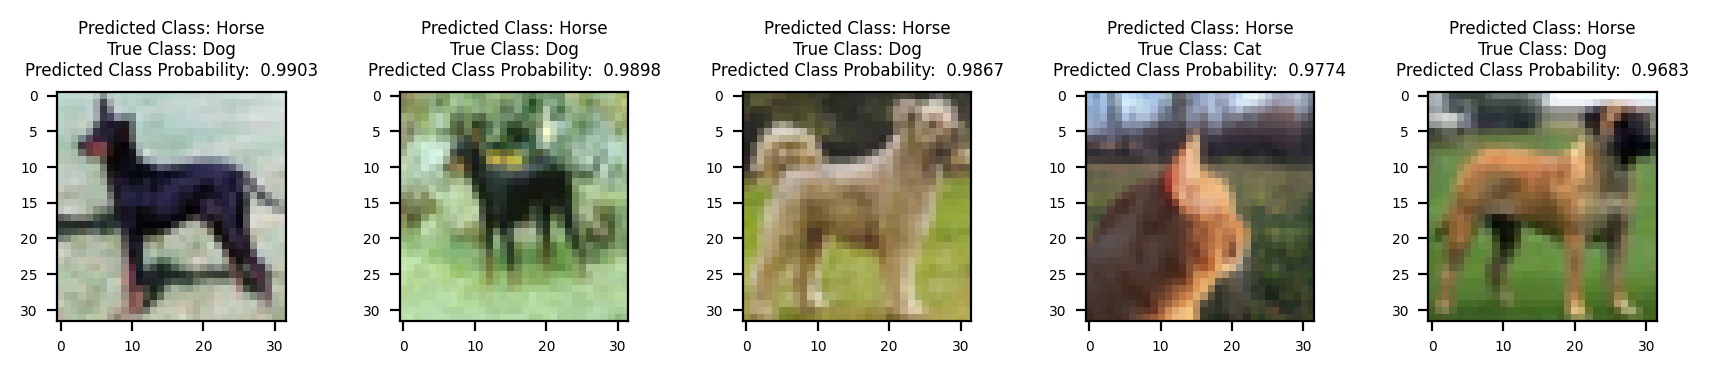

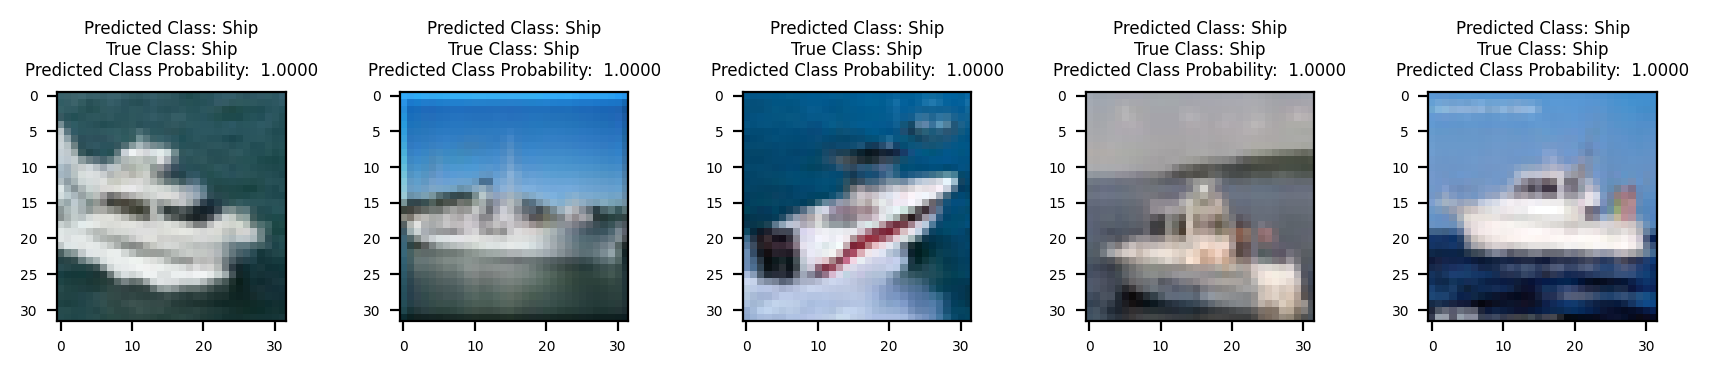

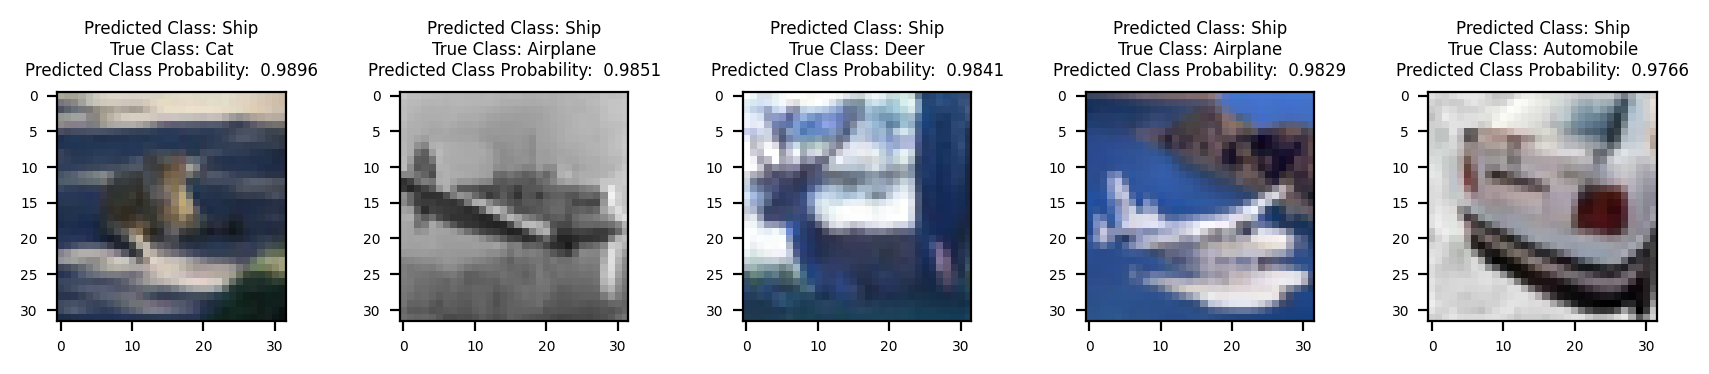

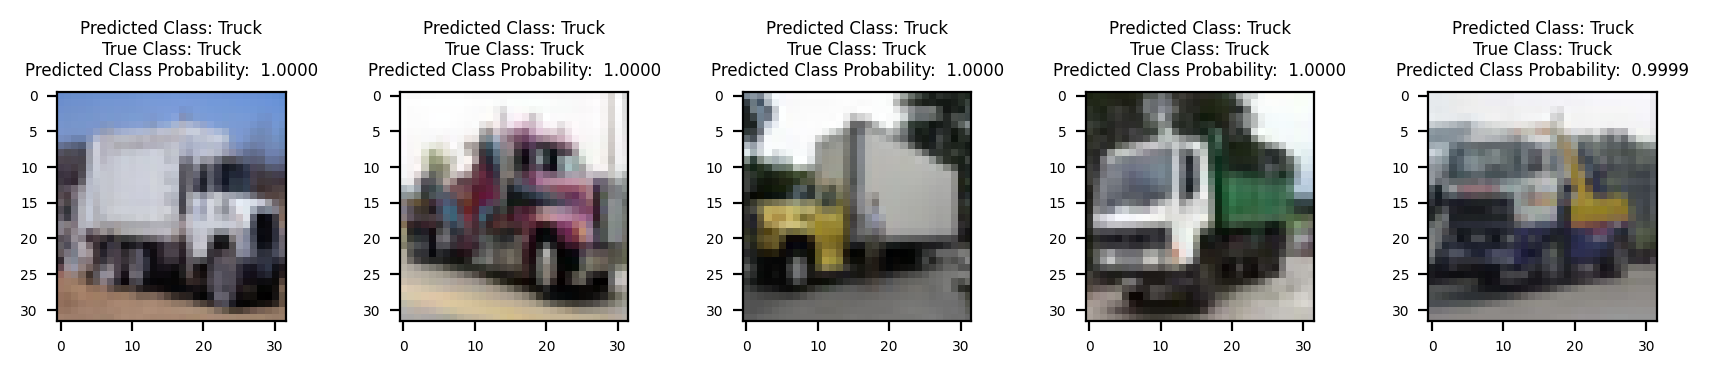

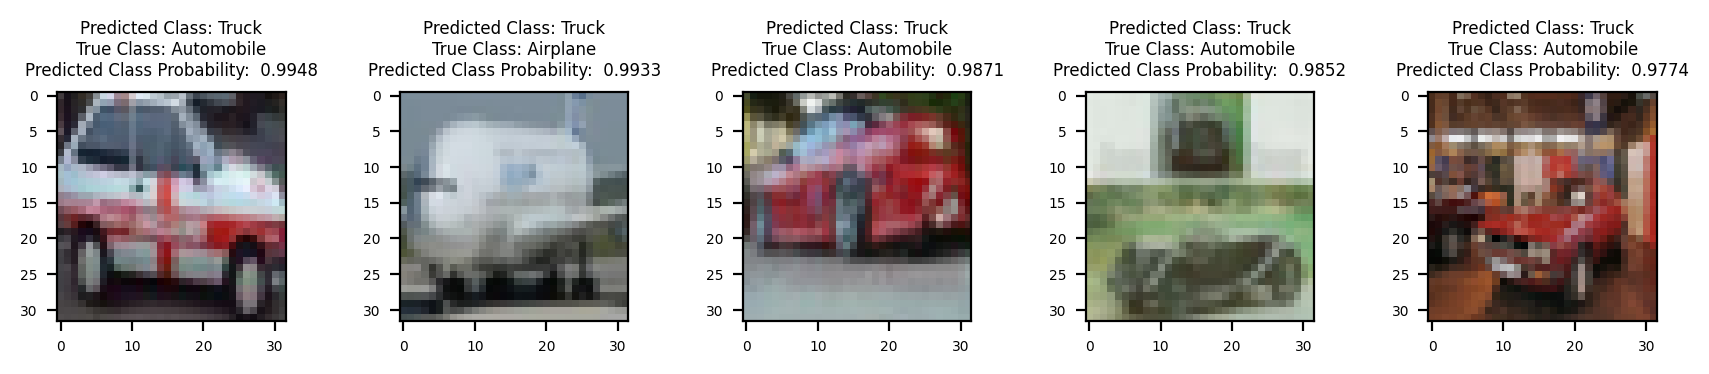

In [39]:
import pandas as pd

def prediction_results(test_results: dict = test_results, test_set = test_set):
    
    # create dataframe from test results for data manipulation
    df = pd.DataFrame(test_results, columns = test_results.keys()).drop(["accuracy", "loss"], axis=1).reset_index()

    # add predicted and true labels to the dataframe
    df["pred_class"] = df["y_pred"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    df["true_class"] = df["y_true"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    # obtain predicted class probability
    df["pred_prob"] = df["probs"].apply(
        lambda x: np.max(x)
    )
    
    # create list of dataframes of top best and worst predictions
    best_predictions = []
    worst_predictions = []
    
    for label in list(CIFAR10_labels.keys()):
        
        # create dataframes of top 5 best and worst predictions
        best_prediction = df.query(str(label)+" == y_true == y_pred").sort_values(by="pred_prob", ascending=False).head(5)
        worst_prediction = df.query(str(label)+" == y_pred != y_true").sort_values(by="pred_prob", ascending=False).head(5)
        
        # append to list of predictions
        best_predictions.append(best_prediction)
        worst_predictions.append(worst_prediction)
    
    # define functino for plotting
    def plotter(df, title):
        fig = plt.figure(figsize=(10,2), dpi = 200)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.4)

        for i, (idx, row) in enumerate(df.iterrows()):

            ax = fig.add_subplot(1, 5, i+1)
            ax.set_title(
                f"Predicted Class: {row[4]}\n"+
                f"True Class: {row[5]}\n"+
                f"Predicted Class Probability: {row[6]: .4f}"
            )
            
            ## print(CIFAR10_labels[test_set[idx][1]])
            
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            plt.imshow(img)
            
    for best_pred, worst_pred in zip(best_predictions, worst_predictions):
        plotter(best_pred, "Correct")
        plotter(worst_pred, "Incorrect")

prediction_results(test_results, test_set)

### Fine tuning model

Similar to the transfer learning model, a `resnet18` model is created and modified to predict 10 labels. However, all parameters are subject to gradient update.

In order to evaluate this models performance against the transfer learning model, we maintain previoulsy selected parameters.

In [31]:
# create transfer learning model
resnet18_tuned = resnet18(weights=ResNet18_Weights.DEFAULT)

# replace last fully connected layer
resnet18_tuned.fc = nn.Linear(num_ftrs, 10)

resnet18_tuned.to(device)

# criterion loss function
criterion = nn.CrossEntropyLoss() # this variable is defined once and we don't change it here

# select optimizer for training
optimizer = optim.Adam(resnet18_tuned.parameters(), lr=1e-3)

### Training

In [32]:
trained_resnet18_tuned = train_model(resnet18_tuned, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.2043	Train Accuracy: 0.5852
Validation Loss: 0.8483	Validation Accuracy: 0.7051

Epoch 2/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.9246	Train Accuracy: 0.6816
Validation Loss: 0.7336	Validation Accuracy: 0.7460

Epoch 3/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8279	Train Accuracy: 0.7178
Validation Loss: 0.7199	Validation Accuracy: 0.7528

Epoch 4/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7551	Train Accuracy: 0.7416
Validation Loss: 0.7299	Validation Accuracy: 0.7625

Epoch 5/5


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6939	Train Accuracy: 0.7622
Validation Loss: 0.6138	Validation Accuracy: 0.7925



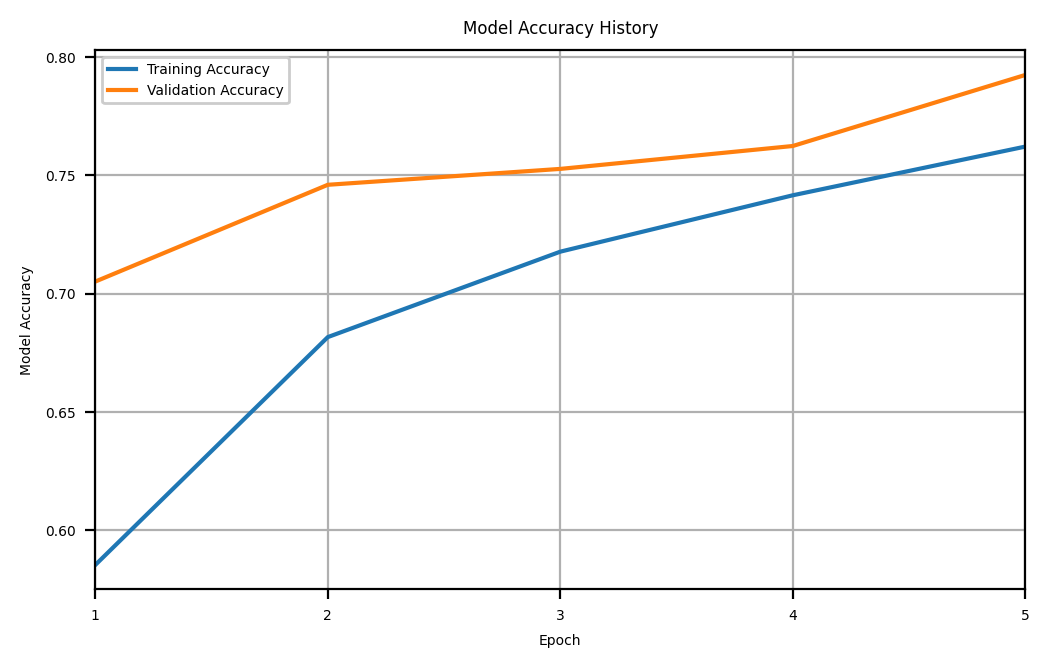

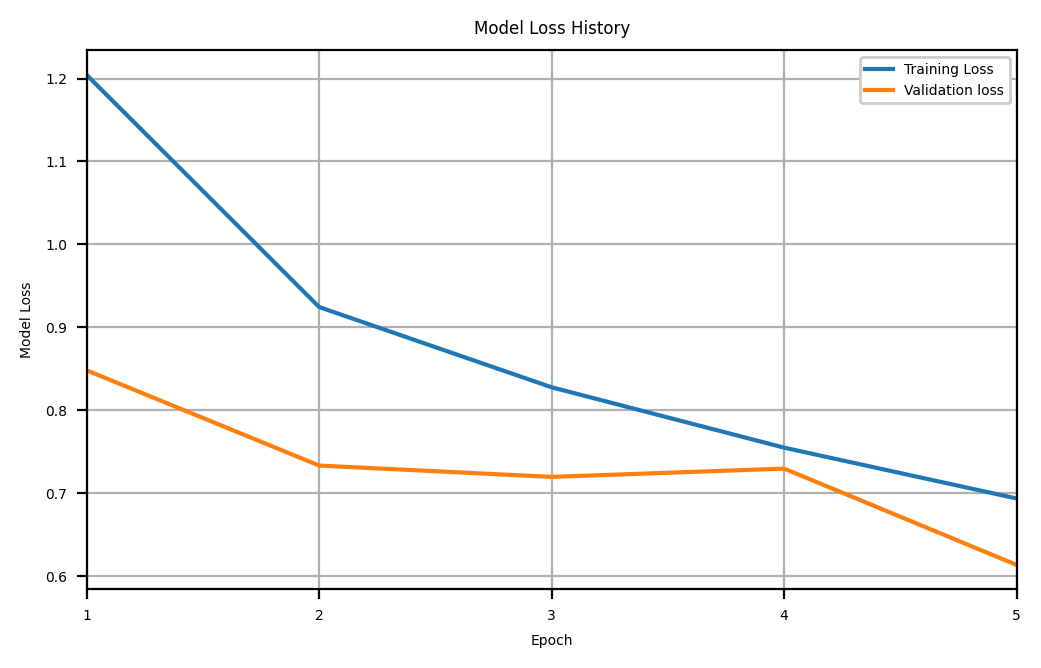

In [33]:
model_history(trained_resnet18_tuned)

### Fine Tuned Model Evaluation

#### Test Accuracy

In [34]:
test_results = evaluate(trained_resnet18_tuned, test_loader)

total_params = sum(p.numel() for p in resnet18_tuned.parameters())
print(f"\nNumber of trainable parameters: {total_params}")

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.7762
Test Loss: 0.6562

Number of trainable parameters: 11181642


The fine tuned model performed much better than the transfer learning model in terms of test accuracy.

#### Confusion Matrix Analysis

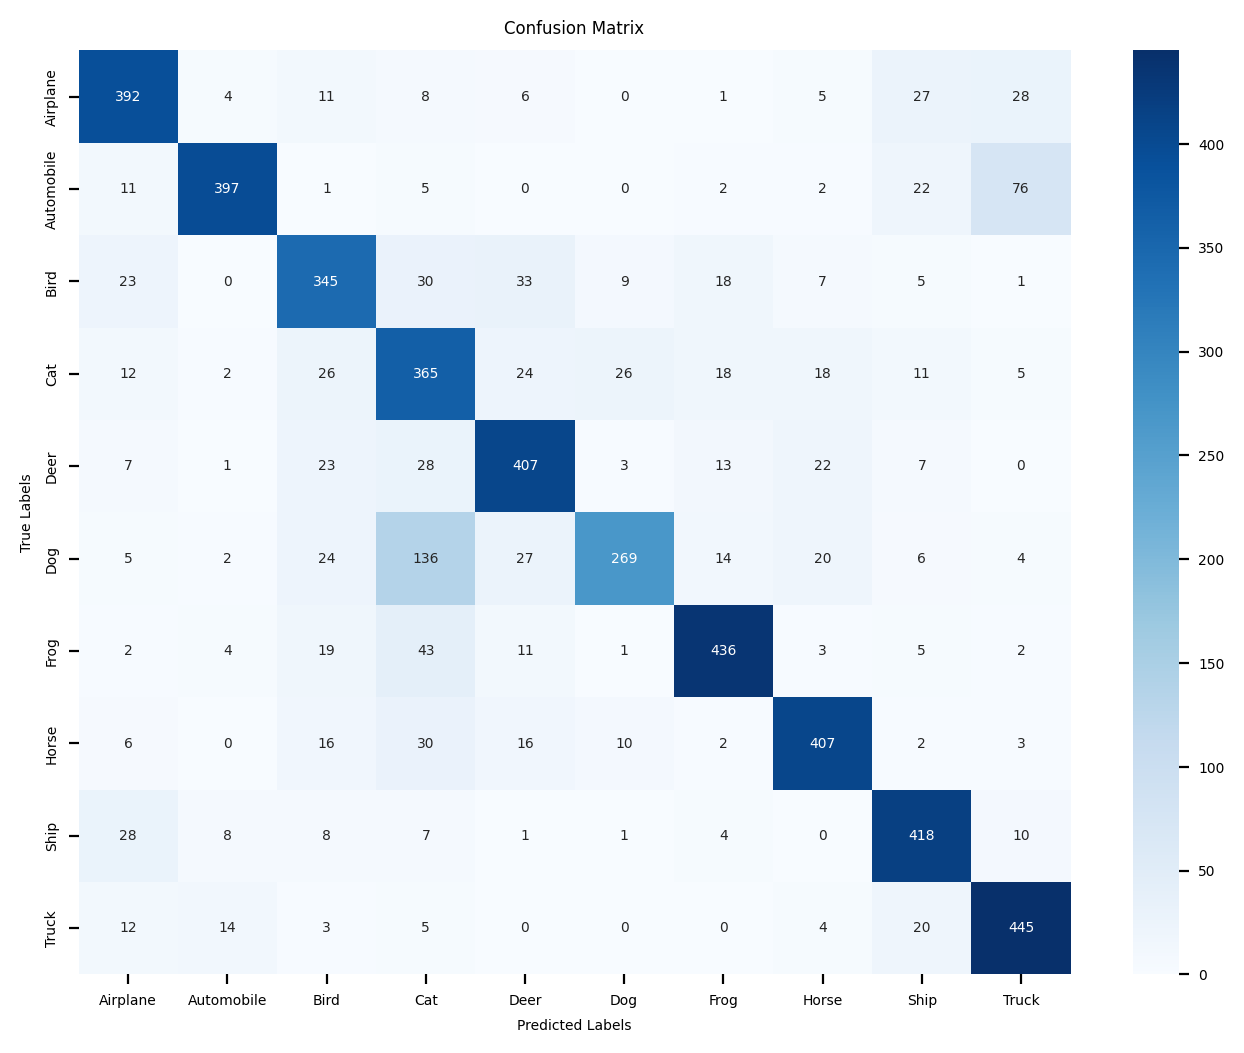

In [35]:
plot_confusion_matrix(test_results)

add results of confusion matrix here

#### Predictions

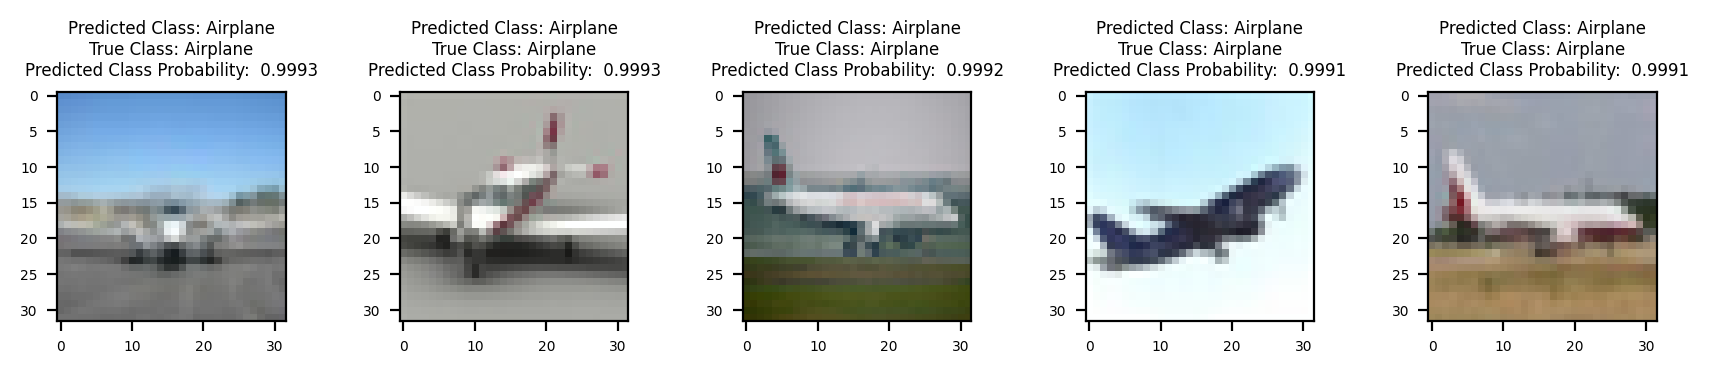

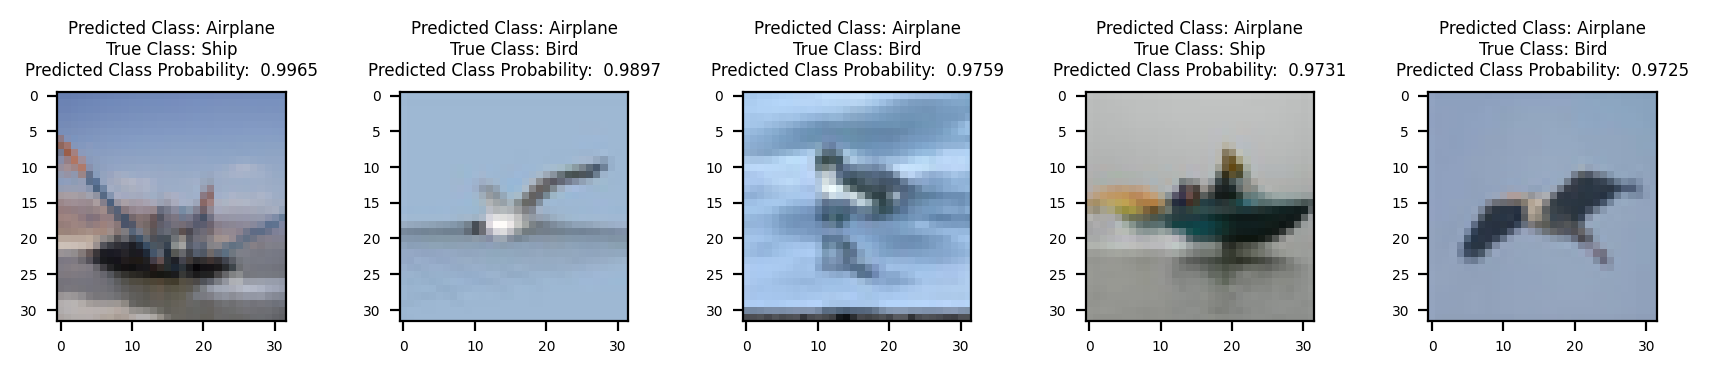

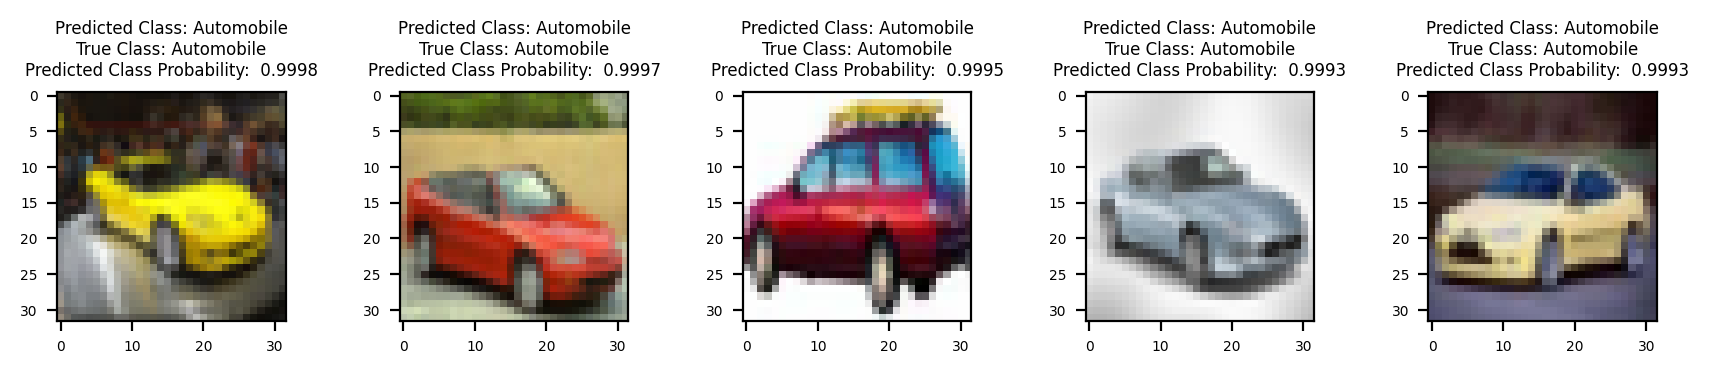

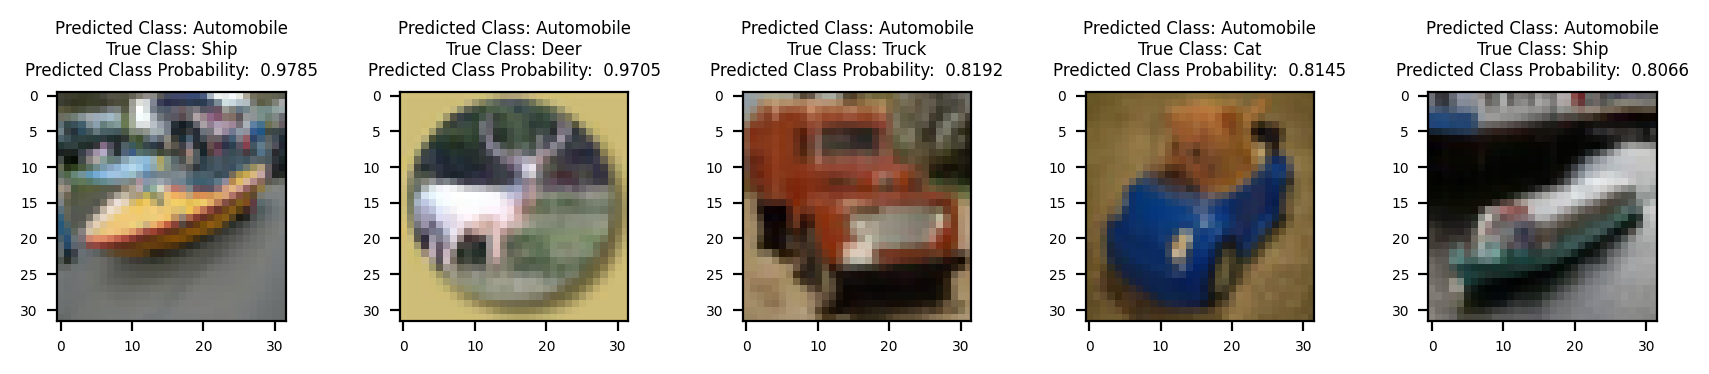

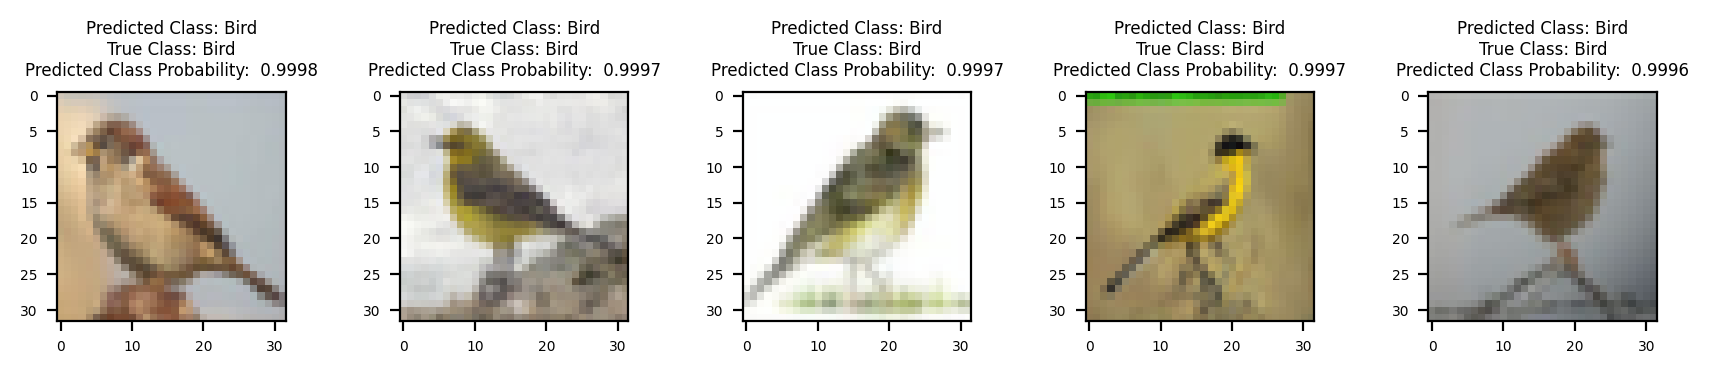

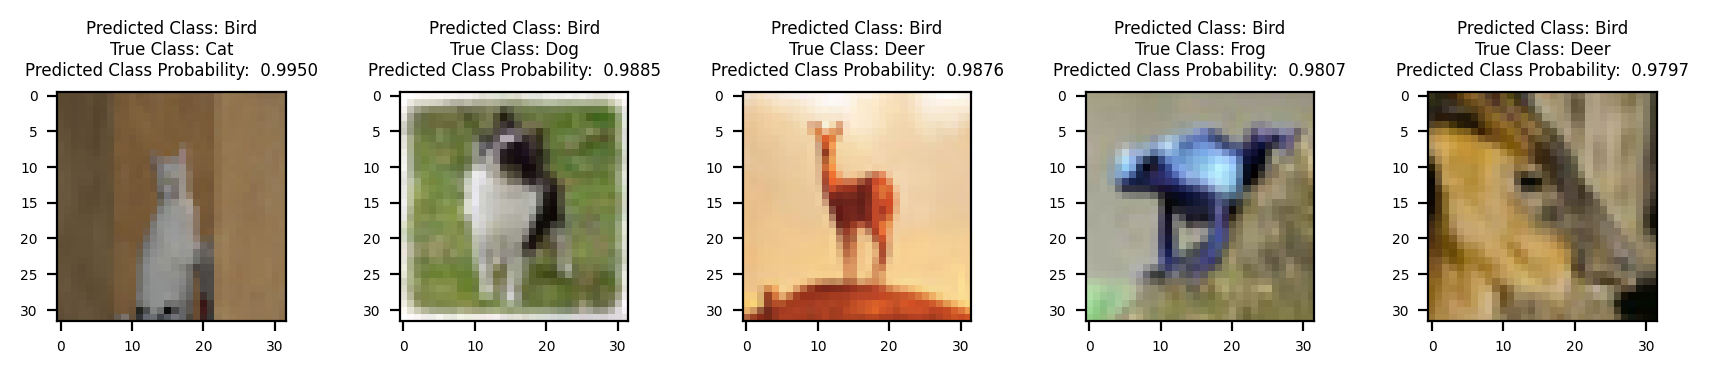

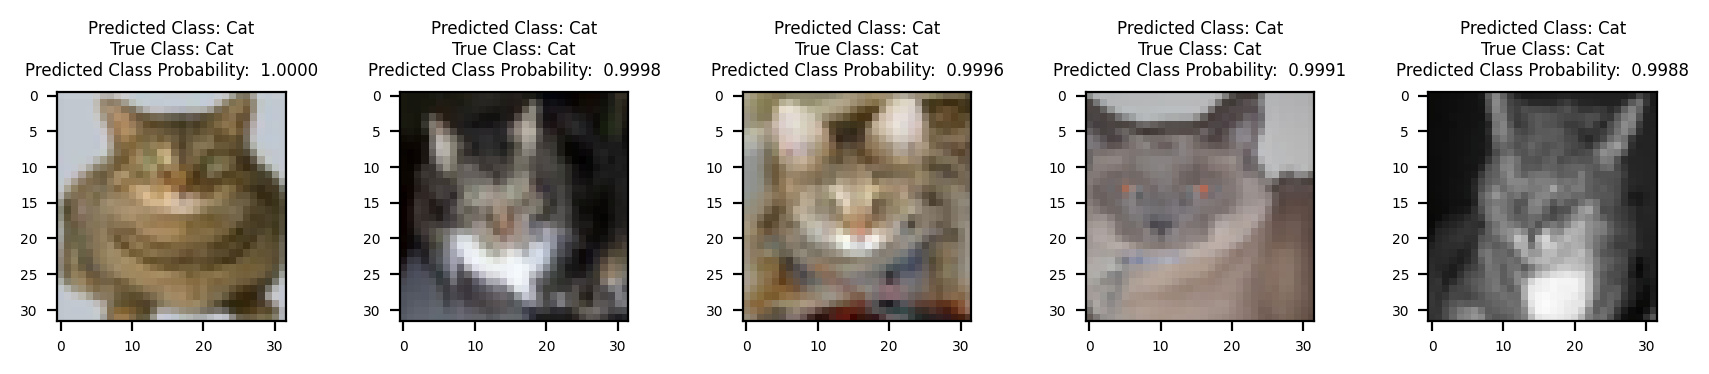

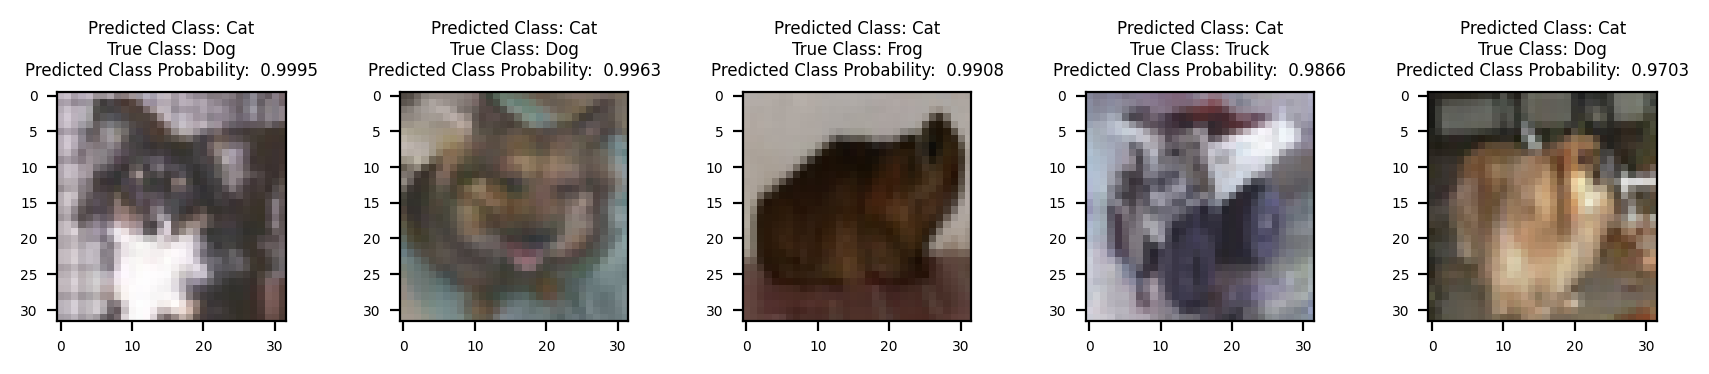

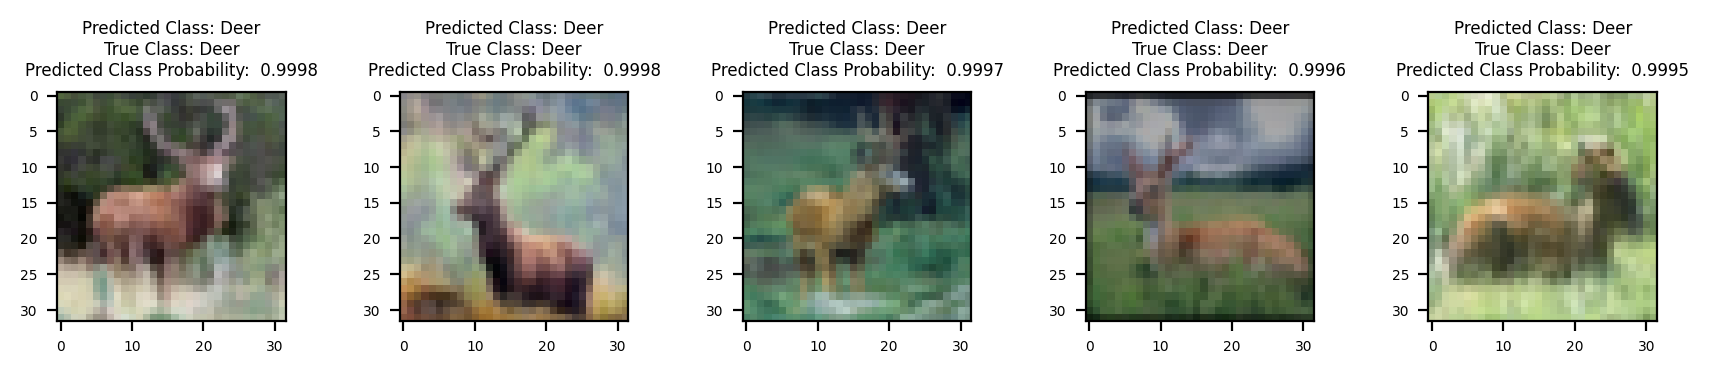

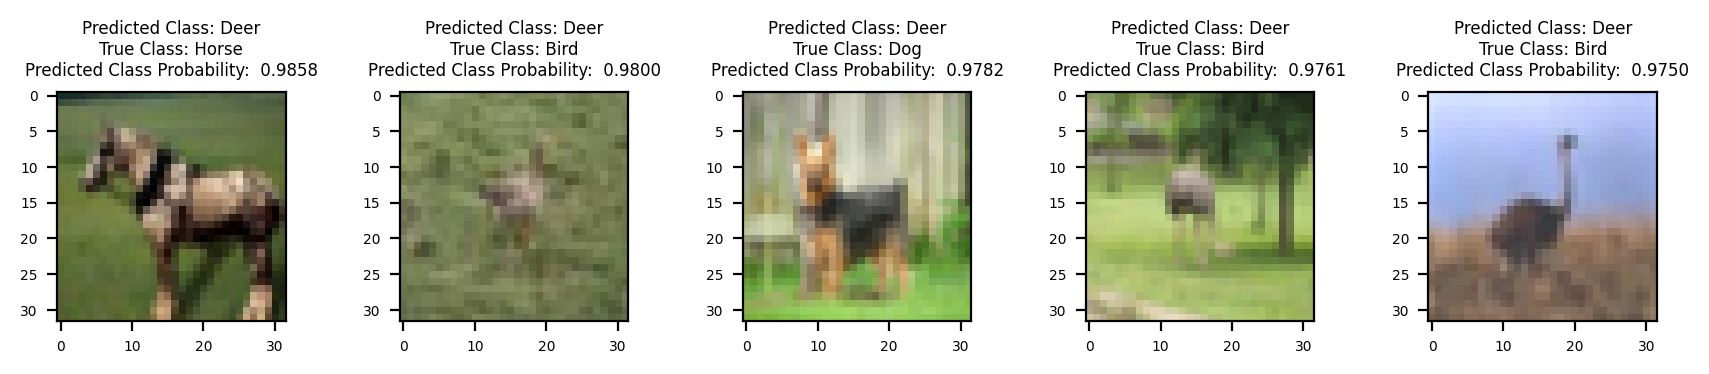

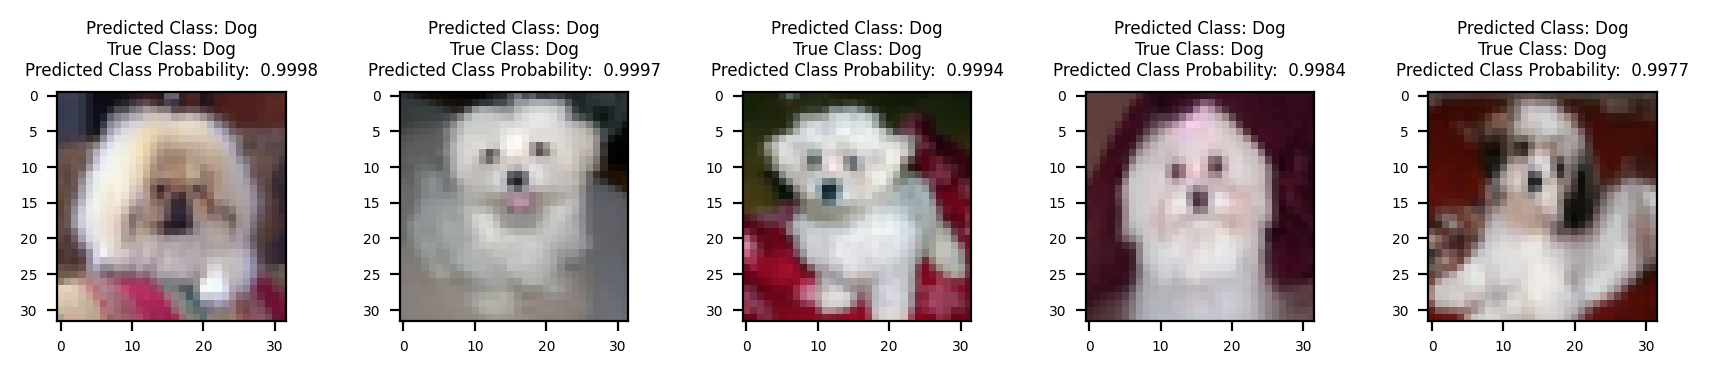

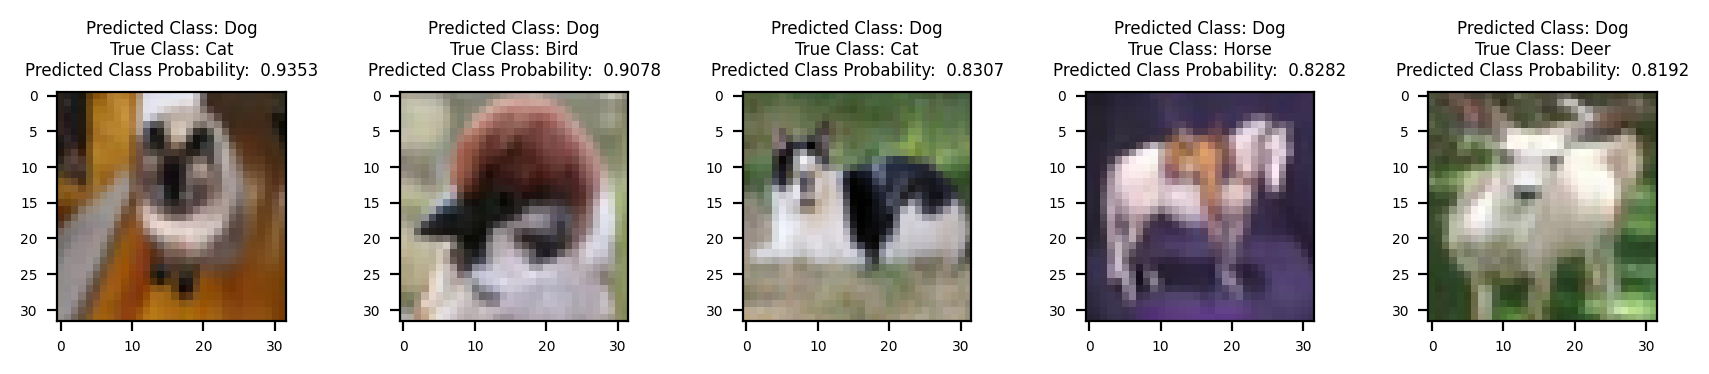

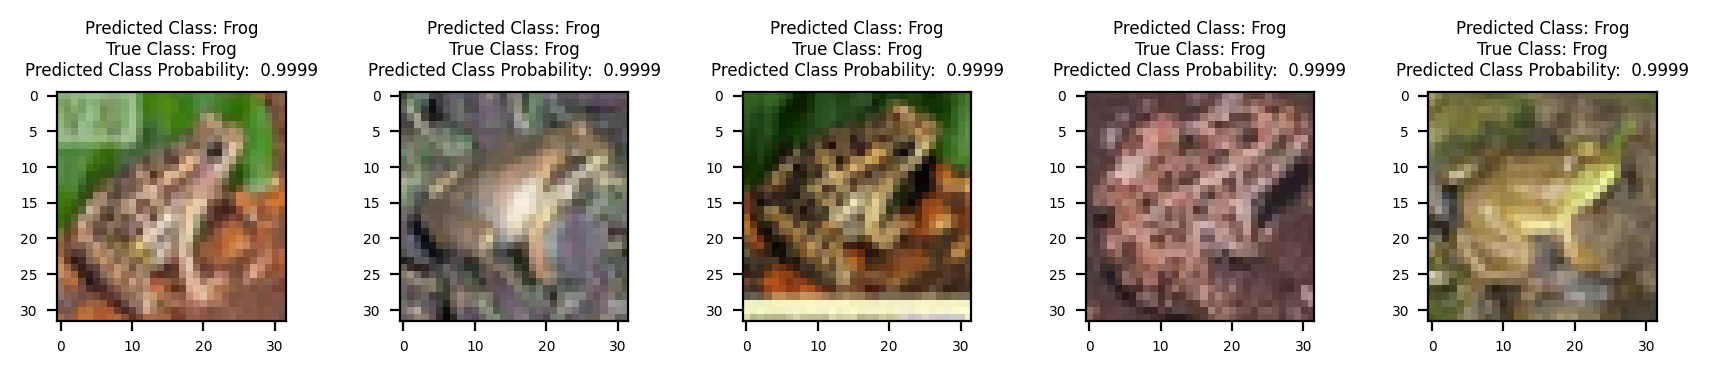

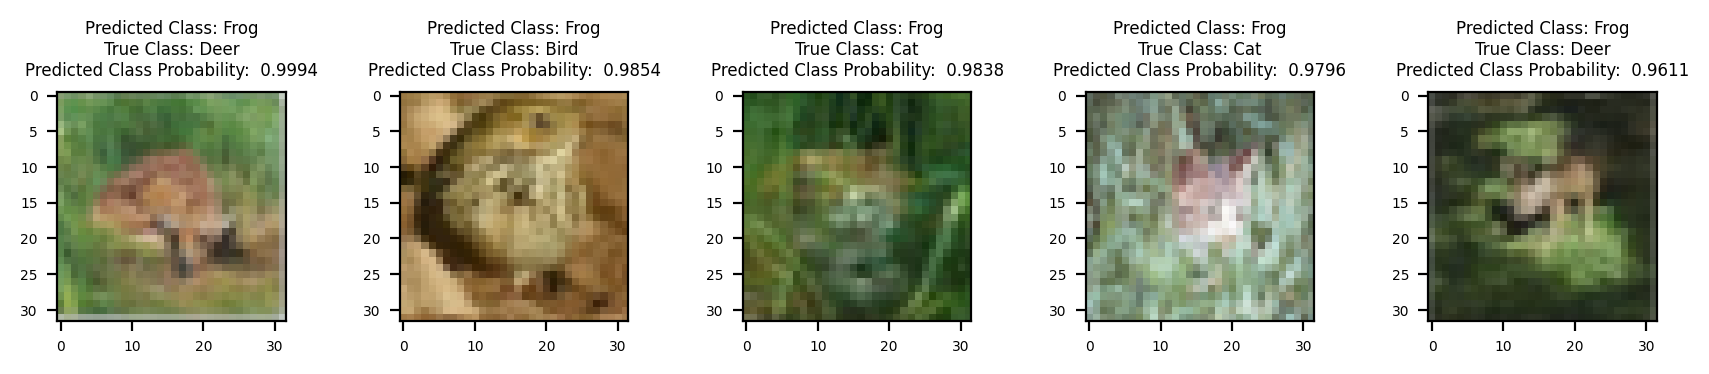

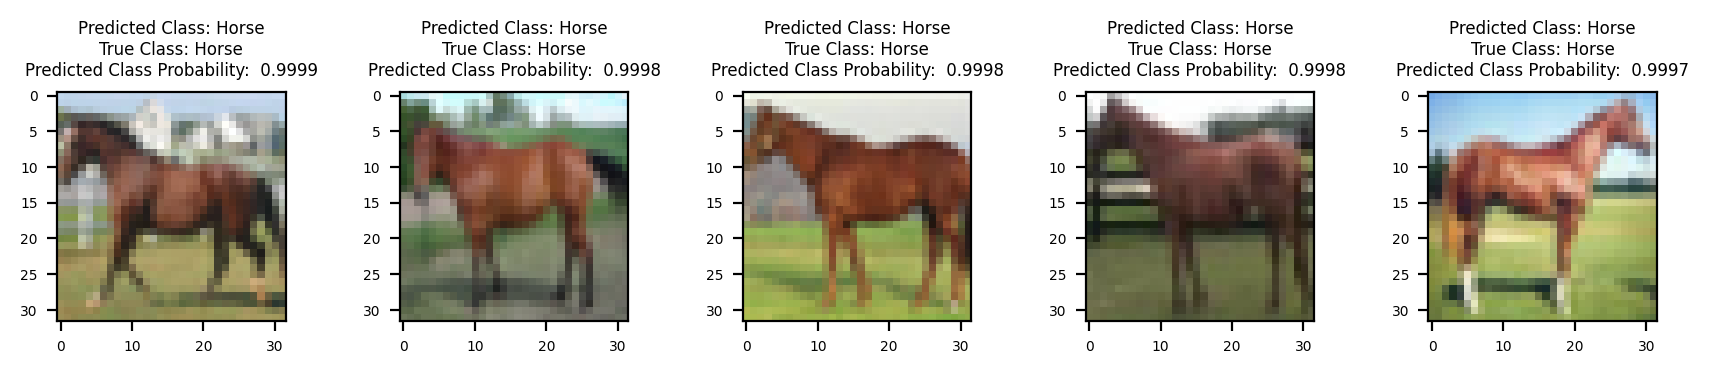

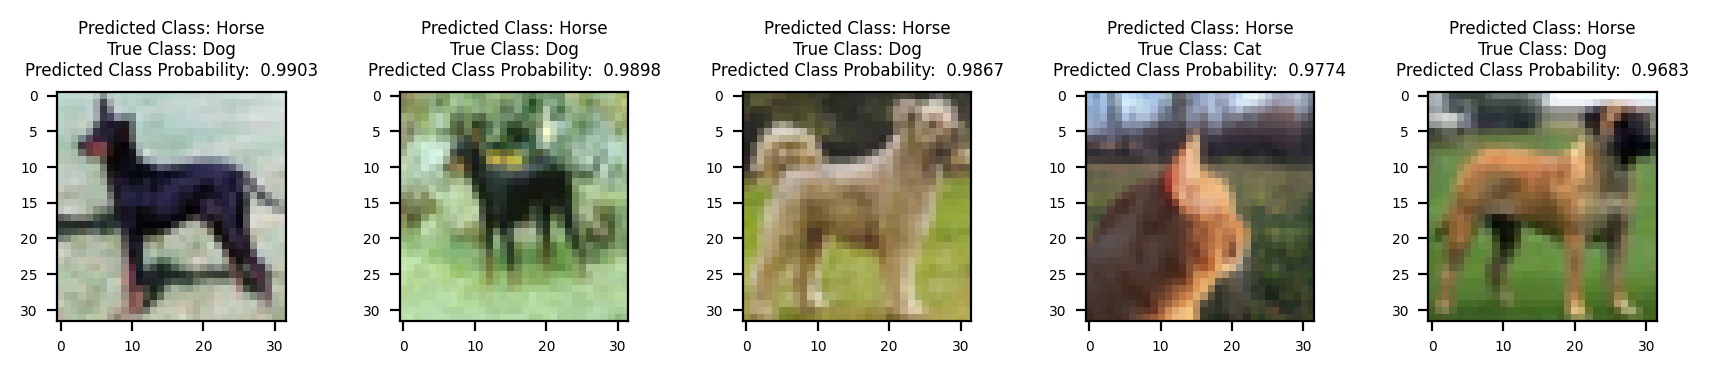

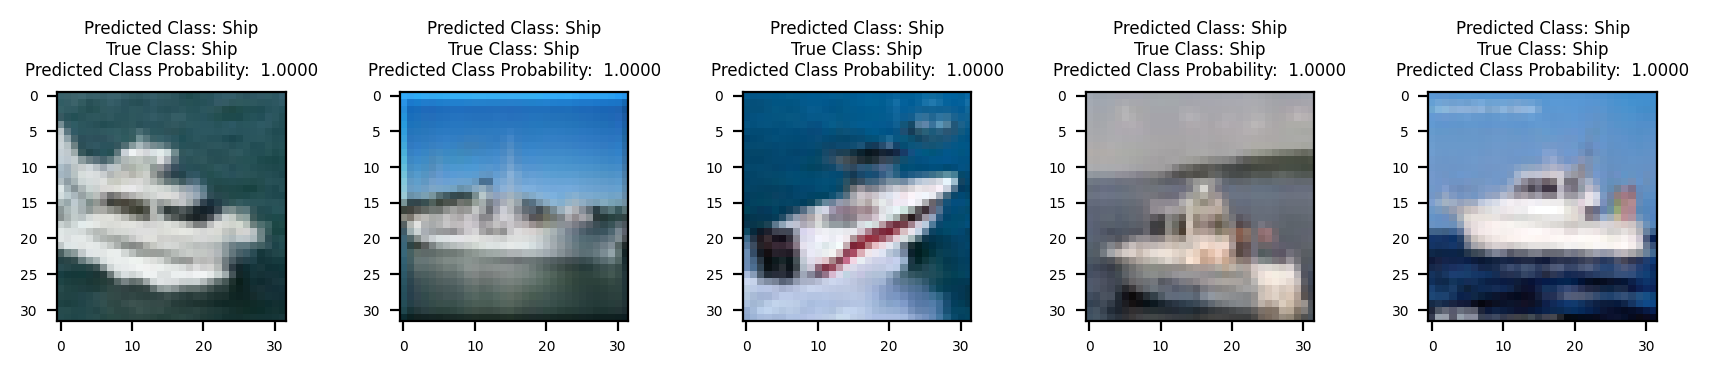

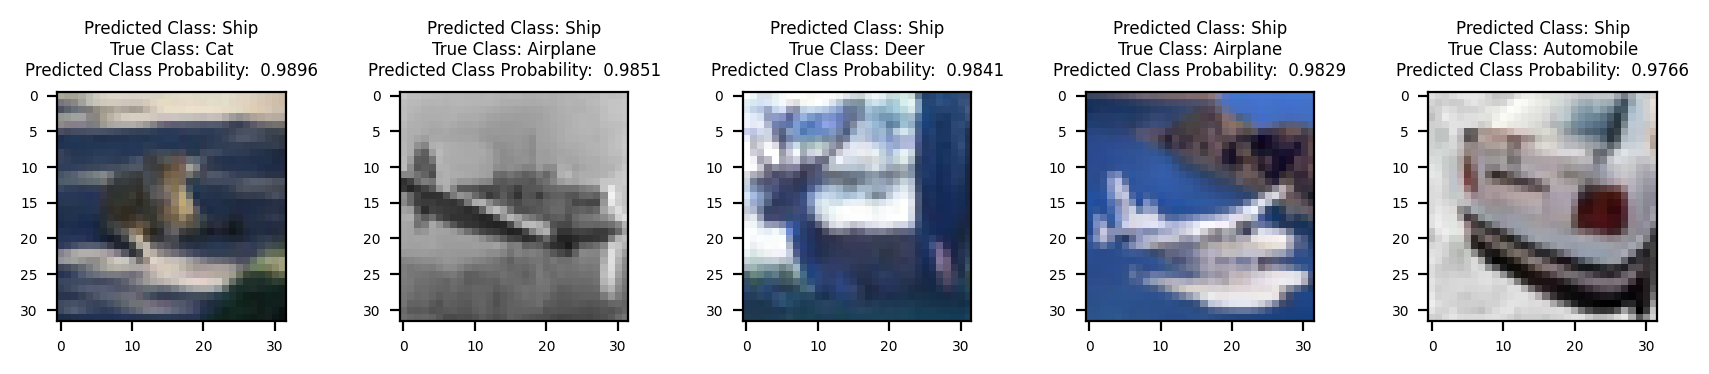

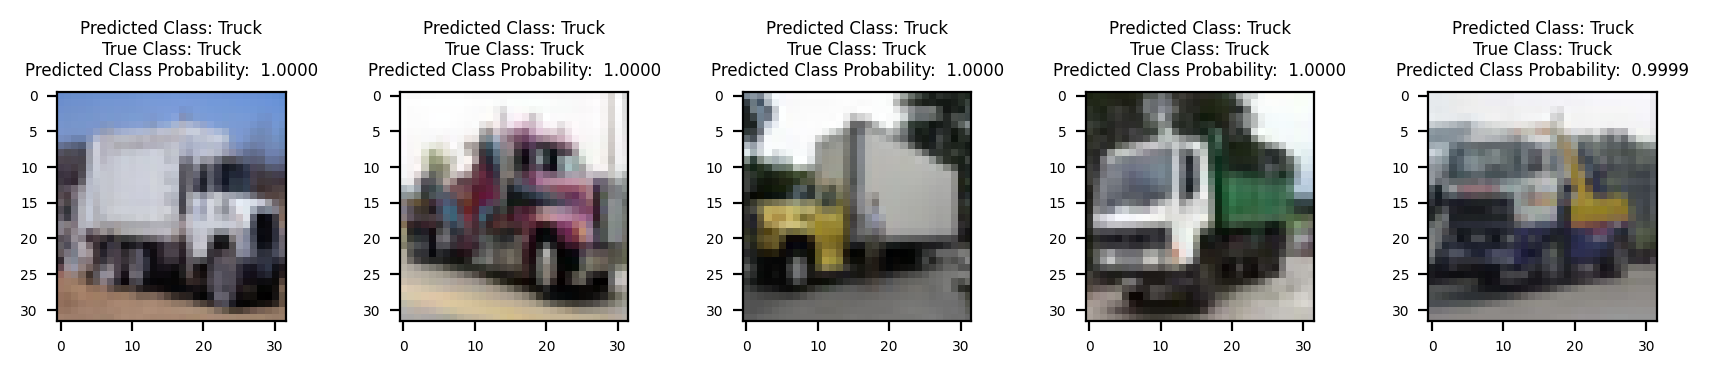

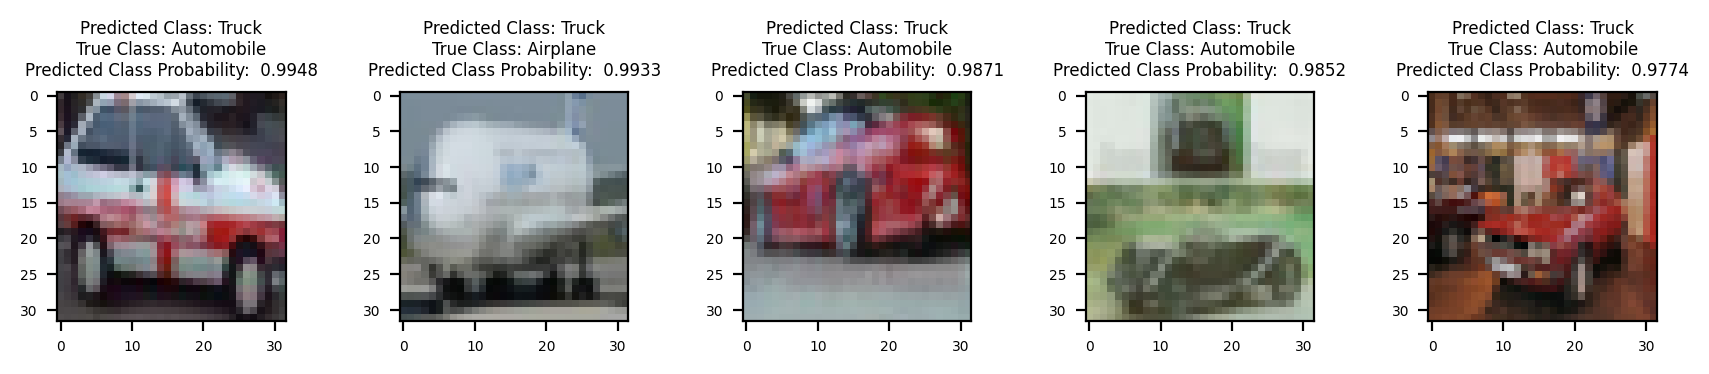

In [36]:
prediction_results(test_results, test_set)

## 2. Movie embeddings

### Data Importation
First, download the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) as `pandas.DataFrame` objects. 

In [89]:
import pandas as pd

path = "Misc_files/movielens_data/ml-latest-small/"

# load movies and ratings DataFrames
movies = pd.read_csv(path+"movies.csv", header=0)
ratings = pd.read_csv(path+"ratings.csv", header=0)

We can then use the `head()` method to see the raw format of these `DataFrame` objects.

In [90]:
n_movies = len(movies)

print(f"Number of Unique Movies: {n_movies}")
movies.head()

Number of Unique Movies: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [91]:
n_ratings = len(ratings)
n_users = ratings.userId.nunique()
n_rated_movies = ratings.movieId.nunique()

print(f"Number of Ratings: {n_ratings}\nNumber of Users: {n_users}\nNumber of Unique Rated Movies: {n_rated_movies}")
ratings.head()

Number of Ratings: 100836
Number of Users: 610
Number of Unique Rated Movies: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Upon inspection of the raw data we note that of the 9,742 movies in the `movies` DataFrame, only 9,724 movies have been rated.

### Preprocessing

#### Embedding Matrix $X$
To obtain the concurrent number of likes $X_{i,j}$ we must first binary encode (`0` or `1`) each `"rating"` in the `ratings` DataFrame. Let us encode the value of liking a movie for each review as such

$$ \text{Liked}(\text{Rating}) =
    \begin{cases}
        1 & \text{if Rating}\geq 4\\
        0 & \text{otherwise}
    \end{cases}$$

and store these values in a new `"liked"` column. We can subsequently drop the unnecessary `rating` and `timestamp` columns after this process.

In [92]:
# create liked column
ratings["liked"] = np.where(ratings["rating"] >= 4, 1, 0)

# drop columns
ratings.drop(["rating", "timestamp"], axis=1, inplace=True)

We next create the `movie_ratings` DataFrame by joing the `movies` and `ratings` DataFrames. Setting the `merge` method parameter `how="left"` ensures that the original number of movies, 9,742, are maintained after the join.

In [93]:
# left join on movieId
movie_ratings = pd.merge(movies, ratings, how="left", on="movieId").reset_index()

A user-likes interaction matrix can then be constructed using the `pivot_table` method, whose rows correspond to the number of unique users `n_users` and columns correspond to the number of unique movies `n_movies` from the original data. This results in a sparse matrix whose rows summarize each users liked movies.

In [94]:
# pivot table on userId
user_likes = movie_ratings.pivot_table(values="liked", index="userId", columns="movieId", dropna=False, fill_value=0)

user_likes

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608.0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Embedding matrix $X$ can now be constructed as the inner (dot) product of the transpose of `user_likes ` and itself. Element $X_{ij} \in X$ corresponds to the number of users that like both movie $i$ and $j$.

In [95]:
# convert to numpy ndarray for dot product computation
user_likes_array = user_likes.to_numpy()

# create X
X_embedding = np.dot(user_likes_array.T, user_likes_array)

# fill diagonals of X with zeros
np.fill_diagonal(X_embedding, 0)

# display as DataFrame for clarity
X_display = pd.DataFrame(X_embedding, index=movies.movieId, columns = movies.movieId)

X_display

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,21,11,0,7,27,7,1,4,19,...,0,0,0,0,0,0,0,0,0,0
2,21,0,5,0,4,8,6,0,0,9,...,0,0,0,0,0,0,0,0,0,0
3,11,5,0,0,4,4,5,1,2,3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,4,4,0,0,3,4,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
193583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Architecture
With preprocessing completed, we convert embedding $X$ into a `torch` tensor object and construct cost function $c$.

In [96]:
X = torch.tensor(X_embedding, dtype = torch.float32)

We implement the below cost function:
$$c(v_1,\ldots, v_M)=\sum_{i=1}^M\sum_{j=1}^M 1_{[i\neq j]}(v_i^T v_j-X_{i,j})^2$$
by creating a superclass of the `torch` `nn.Module` class.

In [97]:
import torch.nn as nn

class cost_function(nn.Module):
    def __init__(self):
        super().__init__()
    
    @ classmethod
    def forward(self, v, X):
        # perform main cost function
        costs = ((1 - torch.eye(n_movies)) * (torch.mm(v.t(), v) - X)**2).sum()
        
        return costs

### Training
We can now devise a training loop `train()` and training schema to evaluate different hyperparameters on our cost function.

In [106]:
# training loop
def train(model, v, X, optimizer, n_epochs=100, verbose = 10):
    
    costs = []
    
    for epoch in tqdm(range(n_epochs)):
        # forward pass
        cost = model.forward(v, X)
        
        # backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        costs.append(cost.item())
        
        if epoch % verbose == 0:
            print(f"Epoch: {epoch}\tCost: {cost: .5f}")
            
    return costs

# hyperparameters to evaluate
learning_rates = [1e-4, 1e-3, 1e-1]
optimizers = ['Adam']

# tracking objects
results = []
trained_vectors = []

# set for epochs
epochs = 20

# Loop over hyperparameters
for optimizer_name in optimizers:
    for lr in learning_rates:
        
        # Print configuration hyperparameters
        print(f"Model Configuration:\noptimizer: {optimizer_name}\nlearning rate: {lr}\n")
        
        # Create a new model for each configuration
        v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
        model = cost_function()
        model.to(device)

        # Define the optimizer based on the chosen name
        if optimizer_name == 'Adam':
            optimizer = optim.Adam([v], lr=lr)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD([v], lr=lr,)# momentum=0.9)

        # Train the model and store the history
        history = train(model, v, X, optimizer, n_epochs=epochs, verbose = 1)

        # Save vectors
        trained_vectors.append(v.detach())

        # Store the results
        result = {
            'learning_rate': lr,
            'optimizer': optimizer_name,
            'loss': history
        }
        
        results.append(result)
        
        print("\n")

Model Configuration:
optimizer: Adam
learning rate: 0.0001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57815220224.00000
Epoch: 1	Cost:  57763098624.00000
Epoch: 2	Cost:  57711017984.00000
Epoch: 3	Cost:  57658982400.00000
Epoch: 4	Cost:  57606987776.00000
Epoch: 5	Cost:  57555054592.00000
Epoch: 6	Cost:  57503170560.00000
Epoch: 7	Cost:  57451327488.00000
Epoch: 8	Cost:  57399537664.00000
Epoch: 9	Cost:  57347796992.00000
Epoch: 10	Cost:  57296113664.00000
Epoch: 11	Cost:  57244483584.00000
Epoch: 12	Cost:  57192906752.00000
Epoch: 13	Cost:  57141370880.00000
Epoch: 14	Cost:  57089888256.00000
Epoch: 15	Cost:  57038467072.00000
Epoch: 16	Cost:  56987103232.00000
Epoch: 17	Cost:  56935792640.00000
Epoch: 18	Cost:  56884531200.00000
Epoch: 19	Cost:  56833335296.00000


Model Configuration:
optimizer: Adam
learning rate: 0.001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57857466368.00000
Epoch: 1	Cost:  57337921536.00000
Epoch: 2	Cost:  56822927360.00000
Epoch: 3	Cost:  56312516608.00000
Epoch: 4	Cost:  55806722048.00000
Epoch: 5	Cost:  55305584640.00000
Epoch: 6	Cost:  54809116672.00000
Epoch: 7	Cost:  54317359104.00000
Epoch: 8	Cost:  53830320128.00000
Epoch: 9	Cost:  53348028416.00000
Epoch: 10	Cost:  52870483968.00000
Epoch: 11	Cost:  52397699072.00000
Epoch: 12	Cost:  51929677824.00000
Epoch: 13	Cost:  51466420224.00000
Epoch: 14	Cost:  51007926272.00000
Epoch: 15	Cost:  50554187776.00000
Epoch: 16	Cost:  50105192448.00000
Epoch: 17	Cost:  49660928000.00000
Epoch: 18	Cost:  49221382144.00000
Epoch: 19	Cost:  48786526208.00000


Model Configuration:
optimizer: Adam
learning rate: 0.1



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57843806208.00000
Epoch: 1	Cost:  24211709952.00000
Epoch: 2	Cost:  11587231744.00000
Epoch: 3	Cost:  6870328832.00000
Epoch: 4	Cost:  5090415104.00000
Epoch: 5	Cost:  4323918848.00000
Epoch: 6	Cost:  3868499968.00000
Epoch: 7	Cost:  3480371712.00000
Epoch: 8	Cost:  3094674432.00000
Epoch: 9	Cost:  2716771072.00000
Epoch: 10	Cost:  2368940288.00000
Epoch: 11	Cost:  2065532416.00000
Epoch: 12	Cost:  1808925440.00000
Epoch: 13	Cost:  1597306624.00000
Epoch: 14	Cost:  1424119040.00000
Epoch: 15	Cost:  1278212864.00000
Epoch: 16	Cost:  1149851520.00000
Epoch: 17	Cost:  1033730368.00000
Epoch: 18	Cost:  927661440.00000
Epoch: 19	Cost:  829878144.00000




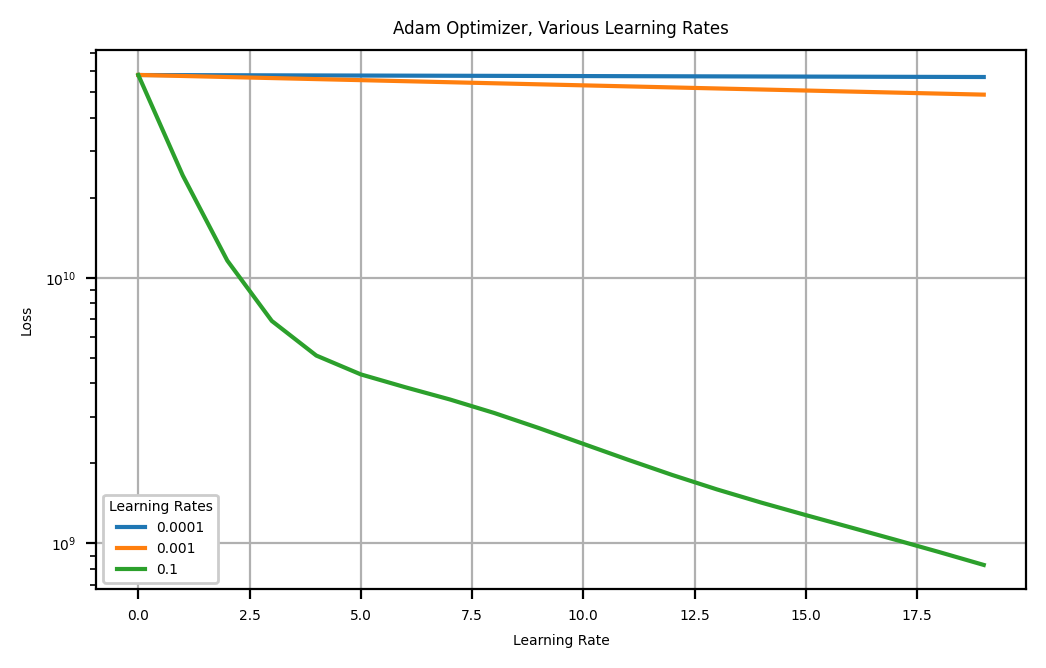

In [108]:
def plot_losses(results):
    
    fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)
    
    optimizer_name = results[0]["optimizer"]
    
    ax.set_title(f"{optimizer_name} Optimizer, Various Learning Rates")
    
    for result in results:
        ax.plot(result["loss"], label=result["learning_rate"])

    # Add labels and legend
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    legend = ax.legend(title='Learning Rates', loc='best')
    legend.get_frame().set_alpha(1.0)

    # Show the plot
    ax.grid(True)

plot_losses(results[:3])

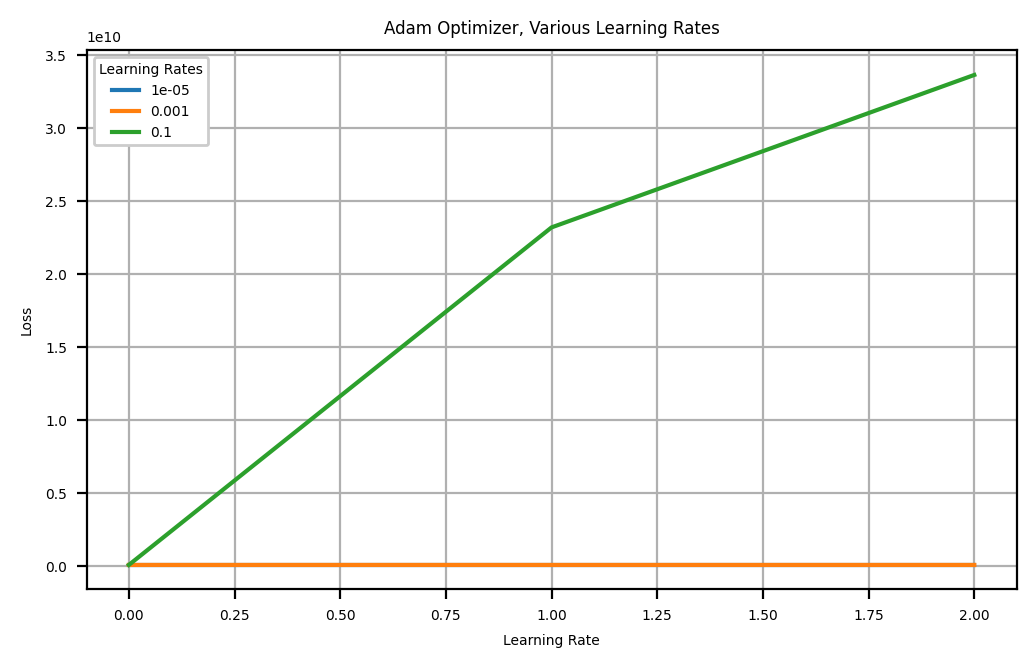

In [104]:
plot_losses(results[3:])